In [99]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 120  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=50 #"local batch size: B"
    bs=50 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.9 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD' #'ADAM'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=0
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [3]:
# load dataset and split users

from torchvision import datasets, transforms

    
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trans_cifar1 = transforms.Compose([transforms.RandomHorizontalFlip(p=1), transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
trans_cifar2 = transforms.Compose([transforms.RandomVerticalFlip(p=1), transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])


dataset_train0 = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
dataset_train1 = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar1)
dataset_train2 = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar2)



# dataset_train = torch.utils.data.ConcatDataset([dataset_train0, dataset_train1, dataset_train2])
dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)

img_size = dataset_train0[0][0].shape

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch.utils.data import DataLoader, Dataset

X_train_np = np.empty((3*len(dataset_train0),32*32*3))
y_train_np = np.empty((3*len(dataset_train0),))
print("size of X:" ,X_train_np.shape)
print("size of Y:" ,y_train_np.shape)

Size_data = 50000

Temp_train = DataLoader(dataset_train0, batch_size=Size_data, shuffle=True)

for batch_idx, (images, labels) in enumerate(Temp_train):
        
    images_np = images.detach().cpu().numpy()    
    X_train_np[0:Size_data,:] = np.reshape(images_np, (Size_data,32*32*3))
    
    labels_np = labels.detach().cpu().numpy()
    
#     print(np.shape(labels_np))
    y_train_np[0:Size_data] = labels_np
    
Temp_train1 = DataLoader(dataset_train1, batch_size=Size_data, shuffle=True)

for batch_idx, (images, labels) in enumerate(Temp_train1):
        
    images_np = images.detach().cpu().numpy()    
    X_train_np[Size_data:2*Size_data,:] = np.reshape(images_np, (Size_data,32*32*3))
    
    labels_np = labels.detach().cpu().numpy()
    y_train_np[Size_data:2*Size_data] = labels_np
    
Temp_train2 = DataLoader(dataset_train2, batch_size=Size_data, shuffle=True)

for batch_idx, (images, labels) in enumerate(Temp_train2):
        
    images_np = images.detach().cpu().numpy()    
    X_train_np[2*Size_data:3*Size_data,:] = np.reshape(images_np, (Size_data,32*32*3))
    
    labels_np = labels.detach().cpu().numpy()
    y_train_np[2*Size_data:3*Size_data] = labels_np
    

size of X: (150000, 3072)
size of Y: (150000,)


In [6]:
num_shards = 120
num_imgs = int(150000 / num_shards)

print(num_shards, num_imgs)

X_train_sorted_np = np.zeros((args.num_classes,15000,32*32*3))
y_train_sorted_np = np.zeros((args.num_classes,15000))

for i in range(args.num_classes):
    
    idxs = np.where(y_train_np == i)
    
    np.random.shuffle(idxs[0])
    
    print(np.shape(idxs[0]))
    
    X_train_sorted_np[i,:,:] = X_train_np[idxs[0],:]
    y_train_sorted_np[i,:]   = y_train_np[idxs[0]]


120 1250
(15000,)
(15000,)
(15000,)
(15000,)
(15000,)
(15000,)
(15000,)
(15000,)
(15000,)
(15000,)


In [7]:
X_train_sorted_np = np.reshape(X_train_sorted_np, (150000, 32*32*3))
y_train_sorted_np = np.reshape(y_train_sorted_np, (150000,))

X_train_alloc_np = np.zeros((args.num_users,num_imgs, 32*32*3))
y_train_alloc_np = np.zeros((args.num_users,num_imgs,))

idx_shard = [i for i in range(num_shards)]
# print(idx_shard)

for i in range(args.num_users):
    rand_set = set(np.random.choice(idx_shard, 1, replace=False))
#     print(i,rand_set)
    idx_shard = list(set(idx_shard) - rand_set)
    
    for rand in rand_set:
        stt_pos = rand*num_imgs
        end_pos = (rand+1)*num_imgs
    
    X_train_alloc_np[i,:,:] = X_train_sorted_np[stt_pos:end_pos,:]
    y_train_alloc_np[i,:] = y_train_sorted_np[stt_pos:end_pos]
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150000, 3072)
4.0
(3, 32, 32)


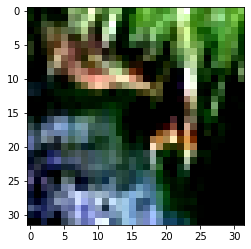

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.0
(3, 32, 32)


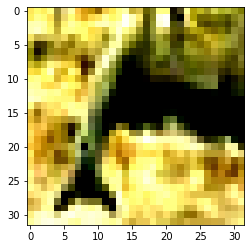

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.0
(3, 32, 32)


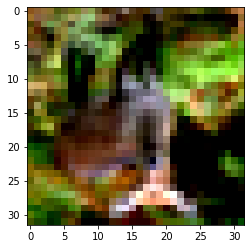

In [11]:
def imshow_np(img):
    img = img / 2 + 0.5     # unnormalize
    
    print(np.shape(img))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
print(np.shape(X_train_np))

user_idx = 117
pic_idx=50
tmp_imag = np.reshape(X_train_alloc_np[user_idx,pic_idx,:],(3,32,32))
print(y_train_alloc_np[user_idx,pic_idx])
imshow_np(tmp_imag)

tmp_imag = np.reshape(X_train_alloc_np[user_idx,pic_idx+1,:],(3,32,32))
print(y_train_alloc_np[user_idx,pic_idx+1])
imshow_np(tmp_imag)

tmp_imag = np.reshape(X_train_alloc_np[user_idx,-1,:],(3,32,32))
print(y_train_alloc_np[user_idx,-1])
imshow_np(tmp_imag)

# tmp_imag = np.reshape(X_train_np[100000+pic_idx,:],(3,32,32))
# print(y_train_np[100000+pic_idx])
# imshow_np(tmp_imag)


# Check the non-iid data distribution

In [101]:
histo_ = np.zeros((10,))

for i in range(args.num_users):

    cur_labels = y_train_alloc_np[i,0]
#     print(np.shape(target))
#     print(target[idxs])
    
    label_first = int(cur_labels)
    
    print(i,'-th user label = ',label_first)
    histo_[label_first] += 1

print(histo_)

0 -th user label =  4
1 -th user label =  0
2 -th user label =  9
3 -th user label =  1
4 -th user label =  3
5 -th user label =  7
6 -th user label =  9
7 -th user label =  7
8 -th user label =  1
9 -th user label =  4
10 -th user label =  4
11 -th user label =  1
12 -th user label =  9
13 -th user label =  1
14 -th user label =  2
15 -th user label =  2
16 -th user label =  8
17 -th user label =  0
18 -th user label =  4
19 -th user label =  1
20 -th user label =  4
21 -th user label =  6
22 -th user label =  1
23 -th user label =  3
24 -th user label =  9
25 -th user label =  0
26 -th user label =  1
27 -th user label =  3
28 -th user label =  5
29 -th user label =  9
30 -th user label =  2
31 -th user label =  0
32 -th user label =  6
33 -th user label =  8
34 -th user label =  3
35 -th user label =  8
36 -th user label =  6
37 -th user label =  2
38 -th user label =  4
39 -th user label =  1
40 -th user label =  2
41 -th user label =  3
42 -th user label =  6
43 -th user label =  

In [103]:
from models.Nets import CNNCifar3
from models.Update import LocalUpdate_NumPyInput
from models.vgg import *

args.local_bs = 50
args.bs = 50
args.local_ep = 1

p = 0
N = 120
K = 12

N_trials = 3
Max_iter = 1000

args.opt = 'SGD'
args.weight_decay = 5e-4
lr_array = [0.01]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []

for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        
        cur_lr = lr_array[lr_idx]
        args.lr = cur_lr
        
        
        print()
        print('Learning Rate =',args.lr)
        print()
#         net_glob = CNNCifar2(args)
        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            
#             if iter <= 1000:
#                 cur_lr = 0.01
#             elif iter <= 1500:
#                 cur_lr = 0.004
#             elif iter <= 2000:
#                 cur_lr = 0.0016
#             else:    
#                 cur_lr = 0.00064

            
            
            
        
            w_locals, loss_locals = [], []

            u = np.random.binomial(1, 1-p, size=(N))

            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)
            print(idxs_users)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
#                 print(idx)
#                 local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                local = LocalUpdate_NumPyInput(args=args, dataset=X_train_alloc_np[idx,:,:], label=y_train_alloc_np[idx,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
            if iter % 100 == 0:
                PATH = "./save_models/CIFAR10_VGG11_Random_E2400_iter"+str(iter)+".pt"
                torch.save(net_glob.state_dict(), PATH)


Learning Rate = 0.01

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[ 44 103  65   2 106  91   1  85  90  76  24  80]

Test set: Average loss: 13.8364 
Accuracy: 1000/10000 (10.00%)

Round   0, Train average loss 0.610 Test accuracy 10.000
[11  8 12 35 16 51 59 30  6 63 87 72]

Test set: Average loss: 10.6034 
Accuracy: 1000/10000 (10.00%)

Round   1, Train average loss 0.858 Test accuracy 10.000
[  2 110  14 113  58  39  29 111  69 112  41  51]

Test set: Average loss: 4.0535 
Accuracy: 844/10000 (8.44%)

Round   2, Train average loss 1.557 Test accuracy 8.440
[112  79   2   7  78   3  58  52  


Test set: Average loss: 3.3236 
Accuracy: 1000/10000 (10.00%)

Round  46, Train average loss 0.529 Test accuracy 10.000
[ 52  17  97  26  34  62  21  44  30  99   8 112]

Test set: Average loss: 2.9104 
Accuracy: 1000/10000 (10.00%)

Round  47, Train average loss 0.556 Test accuracy 10.000
[107  88 118  69  11  55  12  80   1  15  29   0]

Test set: Average loss: 2.7588 
Accuracy: 1000/10000 (10.00%)

Round  48, Train average loss 0.493 Test accuracy 10.000
[ 90   4  68  46  32 117  40  38  89   0   9  50]

Test set: Average loss: 2.9239 
Accuracy: 1000/10000 (10.00%)

Round  49, Train average loss 0.504 Test accuracy 10.000
[47 58 35 13 34 51 91 43  2 74 37  6]

Test set: Average loss: 3.1274 
Accuracy: 1000/10000 (10.00%)

Round  50, Train average loss 0.518 Test accuracy 10.000
[115  91  66  27 118  64  42  16  48  24   0 101]

Test set: Average loss: 3.4600 
Accuracy: 1000/10000 (10.00%)

Round  51, Train average loss 0.576 Test accuracy 10.000
[ 35 111  31  30 102   4  27  76  39


Test set: Average loss: 2.9153 
Accuracy: 1000/10000 (10.00%)

Round  95, Train average loss 0.466 Test accuracy 10.000
[ 45  94   6  55  51 119  74  81  16  28 106  73]

Test set: Average loss: 3.1585 
Accuracy: 1000/10000 (10.00%)

Round  96, Train average loss 0.412 Test accuracy 10.000
[ 87  28  43 103 119  52  76  72  18  84  35  19]

Test set: Average loss: 3.9339 
Accuracy: 1000/10000 (10.00%)

Round  97, Train average loss 0.475 Test accuracy 10.000
[ 76  33  20  65  87  61  49   2  80  25 105  68]

Test set: Average loss: 2.7356 
Accuracy: 1000/10000 (10.00%)

Round  98, Train average loss 0.604 Test accuracy 10.000
[  3  89 102  75  96 100  11  98  94  49  16  31]

Test set: Average loss: 2.8941 
Accuracy: 1000/10000 (10.00%)

Round  99, Train average loss 0.367 Test accuracy 10.000
[ 41  58 105  99  81 101  87  34  73  55  96  70]

Test set: Average loss: 3.1571 
Accuracy: 1000/10000 (10.00%)

Round 100, Train average loss 0.439 Test accuracy 10.000
[  5  95  89  46  87  98


Test set: Average loss: 3.2678 
Accuracy: 1000/10000 (10.00%)

Round 144, Train average loss 0.406 Test accuracy 10.000
[ 78   3   9   1   0  18  91  26 110  51  45  64]

Test set: Average loss: 3.0460 
Accuracy: 1000/10000 (10.00%)

Round 145, Train average loss 0.490 Test accuracy 10.000
[ 86  25  74  64 111  75  52  36  65  60  21  24]

Test set: Average loss: 3.1699 
Accuracy: 1000/10000 (10.00%)

Round 146, Train average loss 0.492 Test accuracy 10.000
[ 88  82  73 109  67  35  49  46  56  84  63  71]

Test set: Average loss: 3.7334 
Accuracy: 1000/10000 (10.00%)

Round 147, Train average loss 0.459 Test accuracy 10.000
[ 32  92 103  46  45   9  61  65  67 114  38  30]

Test set: Average loss: 2.5563 
Accuracy: 1000/10000 (10.00%)

Round 148, Train average loss 0.673 Test accuracy 10.000
[95 45 49 70 54 21 80 12 41 17 15 32]

Test set: Average loss: 2.7193 
Accuracy: 1000/10000 (10.00%)

Round 149, Train average loss 0.480 Test accuracy 10.000
[ 32  42  75  29  54   8  71   5  60


Test set: Average loss: 2.9842 
Accuracy: 1000/10000 (10.00%)

Round 193, Train average loss 0.501 Test accuracy 10.000
[ 99 113 109 108  23  64 100  40  98  94  73  72]

Test set: Average loss: 2.9320 
Accuracy: 1000/10000 (10.00%)

Round 194, Train average loss 0.620 Test accuracy 10.000
[ 47 111  31  38 107   6  11 108   4   0  72  66]

Test set: Average loss: 2.7757 
Accuracy: 1000/10000 (10.00%)

Round 195, Train average loss 0.419 Test accuracy 10.000
[ 44  26  35  15 111   5  34  12  22  14  19  55]

Test set: Average loss: 2.8702 
Accuracy: 1000/10000 (10.00%)

Round 196, Train average loss 0.438 Test accuracy 10.000
[57 90 53  4 88 29 47  7 44 43 81 13]

Test set: Average loss: 2.6603 
Accuracy: 1000/10000 (10.00%)

Round 197, Train average loss 0.378 Test accuracy 10.000
[101  75  68  22   4  52  88  24  70   1 104  65]

Test set: Average loss: 2.9063 
Accuracy: 1000/10000 (10.00%)

Round 198, Train average loss 0.399 Test accuracy 10.000
[ 77  15  48   4  81  94   0  56  13


Test set: Average loss: 2.8987 
Accuracy: 1000/10000 (10.00%)

Round 242, Train average loss 0.428 Test accuracy 10.000
[ 17   7  81 103  78 107  22  76   0  46  53  30]

Test set: Average loss: 2.7884 
Accuracy: 1007/10000 (10.07%)

Round 243, Train average loss 0.433 Test accuracy 10.070
[ 16  79 111  87  71 106  80  73 118  48 103 104]

Test set: Average loss: 2.7054 
Accuracy: 1000/10000 (10.00%)

Round 244, Train average loss 0.349 Test accuracy 10.000
[  7  88  74  26  98 113  86  60  70  78  99  87]

Test set: Average loss: 3.2214 
Accuracy: 1000/10000 (10.00%)

Round 245, Train average loss 0.322 Test accuracy 10.000
[ 34  77  81  52  35 105  63  70  65  48  29  71]

Test set: Average loss: 3.2432 
Accuracy: 1000/10000 (10.00%)

Round 246, Train average loss 0.455 Test accuracy 10.000
[110   8  40   9  45  59  83  12   3  50  96  37]

Test set: Average loss: 3.3170 
Accuracy: 1000/10000 (10.00%)

Round 247, Train average loss 0.408 Test accuracy 10.000
[ 63  54   0 118  51  16


Test set: Average loss: 2.7346 
Accuracy: 1000/10000 (10.00%)

Round 291, Train average loss 0.434 Test accuracy 10.000
[106  16  54  35  30 109  20  90  39 113  61  72]

Test set: Average loss: 2.8920 
Accuracy: 1000/10000 (10.00%)

Round 292, Train average loss 0.466 Test accuracy 10.000
[ 39  66 103  14  92   4  38   2  94  71  59  11]

Test set: Average loss: 2.9798 
Accuracy: 1000/10000 (10.00%)

Round 293, Train average loss 0.405 Test accuracy 10.000
[ 21   8  20 111  92 116  78  29  83  39  49  51]

Test set: Average loss: 3.1593 
Accuracy: 1000/10000 (10.00%)

Round 294, Train average loss 0.440 Test accuracy 10.000
[ 31  88 101  26  18   5  92 110  67  56  61  46]

Test set: Average loss: 3.3973 
Accuracy: 1000/10000 (10.00%)

Round 295, Train average loss 0.482 Test accuracy 10.000
[114 112   0  37  88  23  26   3  14  59  21  75]

Test set: Average loss: 3.1445 
Accuracy: 1000/10000 (10.00%)

Round 296, Train average loss 0.534 Test accuracy 10.000
[ 21  26  15  40  66  19


Test set: Average loss: 2.8710 
Accuracy: 1000/10000 (10.00%)

Round 340, Train average loss 0.365 Test accuracy 10.000
[ 60  75  98  32  67  38  14   0  59  28  17 102]

Test set: Average loss: 3.0833 
Accuracy: 1000/10000 (10.00%)

Round 341, Train average loss 0.439 Test accuracy 10.000
[  9  29  92  69  97  99  88   6  76  93 119  50]

Test set: Average loss: 2.5301 
Accuracy: 1000/10000 (10.00%)

Round 342, Train average loss 0.496 Test accuracy 10.000
[46  0 28 44 80 48 50 25 12 96 21 88]

Test set: Average loss: 2.6332 
Accuracy: 997/10000 (9.97%)

Round 343, Train average loss 0.361 Test accuracy 9.970
[ 33  19  93 100  38  69 119  59  75 106  46 116]

Test set: Average loss: 3.0929 
Accuracy: 1000/10000 (10.00%)

Round 344, Train average loss 0.360 Test accuracy 10.000
[  4  63 102  21  27  70 110   8 119  35  16 114]

Test set: Average loss: 2.9108 
Accuracy: 998/10000 (9.98%)

Round 345, Train average loss 0.359 Test accuracy 9.980
[ 53   3  85  31  29  91  56  80 114 110 1


Test set: Average loss: 2.6723 
Accuracy: 1000/10000 (10.00%)

Round 389, Train average loss 0.410 Test accuracy 10.000
[  5  47  72   6  94 116  43 103  44  27  93  96]

Test set: Average loss: 2.7059 
Accuracy: 1000/10000 (10.00%)

Round 390, Train average loss 0.409 Test accuracy 10.000
[ 52  67  41  80 115  26  61  97  46  71  30   9]

Test set: Average loss: 2.7501 
Accuracy: 1000/10000 (10.00%)

Round 391, Train average loss 0.382 Test accuracy 10.000
[ 51  61  80  58  47  41 102  48  73  24   4  78]

Test set: Average loss: 2.8400 
Accuracy: 1000/10000 (10.00%)

Round 392, Train average loss 0.418 Test accuracy 10.000
[85 74 50 61 51 95 20 34 17 12 39 75]

Test set: Average loss: 2.8203 
Accuracy: 1000/10000 (10.00%)

Round 393, Train average loss 0.404 Test accuracy 10.000
[57 27  0 79 65 94 13 36 85  8 93 14]

Test set: Average loss: 3.0381 
Accuracy: 1000/10000 (10.00%)

Round 394, Train average loss 0.342 Test accuracy 10.000
[ 83   8   9  61  50  44  25 109  60  82  33  14


Test set: Average loss: 3.0507 
Accuracy: 1000/10000 (10.00%)

Round 438, Train average loss 0.401 Test accuracy 10.000
[  3 108  20 119  86  51  45  39   6  73  63  25]

Test set: Average loss: 2.7258 
Accuracy: 1000/10000 (10.00%)

Round 439, Train average loss 0.335 Test accuracy 10.000
[111 119  77 114  36  15 113  55  69  56  49  90]

Test set: Average loss: 2.7576 
Accuracy: 1000/10000 (10.00%)

Round 440, Train average loss 0.435 Test accuracy 10.000
[  1  28  68  64  19 102  67  24  20  91   3 106]

Test set: Average loss: 3.1319 
Accuracy: 1000/10000 (10.00%)

Round 441, Train average loss 0.442 Test accuracy 10.000
[ 82  70  22  91  41 106  49  51  89  61   1  13]

Test set: Average loss: 2.9233 
Accuracy: 1000/10000 (10.00%)

Round 442, Train average loss 0.323 Test accuracy 10.000
[113  55 108  68  91  50  32  46  16   5 105  78]

Test set: Average loss: 3.0904 
Accuracy: 1000/10000 (10.00%)

Round 443, Train average loss 0.447 Test accuracy 10.000
[28 72 24 51 97 43 67  3


Test set: Average loss: 2.8180 
Accuracy: 1000/10000 (10.00%)

Round 487, Train average loss 0.400 Test accuracy 10.000
[ 17  84 116  87  40  33  77  97  21   9  75  64]

Test set: Average loss: 3.8670 
Accuracy: 1000/10000 (10.00%)

Round 488, Train average loss 0.402 Test accuracy 10.000
[ 74  38  75 109   8  33  94  67  10 113  93  98]

Test set: Average loss: 2.8869 
Accuracy: 999/10000 (9.99%)

Round 489, Train average loss 0.507 Test accuracy 9.990
[ 38  22  13 108  27  46  40  58  61   0 118  80]

Test set: Average loss: 2.7764 
Accuracy: 1000/10000 (10.00%)

Round 490, Train average loss 0.330 Test accuracy 10.000
[107  76  88   0  95  62  97   4  59  57  17   3]

Test set: Average loss: 3.2690 
Accuracy: 1000/10000 (10.00%)

Round 491, Train average loss 0.329 Test accuracy 10.000
[100  36  51 112  35  14 108  15  21 110  60 106]

Test set: Average loss: 3.3015 
Accuracy: 1000/10000 (10.00%)

Round 492, Train average loss 0.512 Test accuracy 10.000
[108  58 109  46 102  20  5

KeyboardInterrupt: 

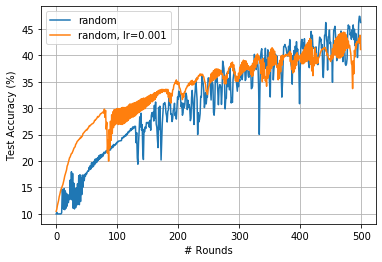

In [18]:
plt.plot(acc_test_arr[0,0,:], label='random')
plt.plot(acc_test_arr[1,0,:], label='random, lr='+str(0.001))
# plt.plot(acc_test_arr_partition[:], label='partition')
# plt.plot(acc_test_arr_Proposed_N40_K8_T4[:], label='proposed, T=4')
# plt.plot(acc_test_arr_Proposed_N40_K8_T2[:], label='proposed, T=2')
# plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

In [28]:
from models.Nets import CNNCifar2, CNNCifar3
from models.Update import LocalUpdate_NumPyInput
from models.vgg import *

args.local_bs = 250
args.bs = 250
args.local_ep = 1

p = 0
N = 120
K = 120

N_trials = 1
Max_iter = 200

args.opt = 'SGD'
args.weight_decay = 5e-4
lr_array = [0.01]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []

for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        
        cur_lr = lr_array[lr_idx]
        args.lr = cur_lr
        
        
        print()
        print('Learning Rate =',args.lr)
        print()
#         net_glob = CNNCifar2(args)
        net_glob = CNNCifar2(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            
#             if iter <= 1000:
#                 cur_lr = 0.01
#             elif iter <= 1500:
#                 cur_lr = 0.004
#             elif iter <= 2000:
#                 cur_lr = 0.0016
#             else:    
#                 cur_lr = 0.00064

            
            
            
        
            w_locals, loss_locals = [], []

            u = np.random.binomial(1, 1-p, size=(N))

            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)
            print(idxs_users)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
#                 print(idx)
#                 local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                local = LocalUpdate_NumPyInput(args=args, dataset=X_train_alloc_np[idx,:,:], label=y_train_alloc_np[idx,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
#             if iter % 100 == 99:
#                 PATH = "./save_models/CIFAR10_CNN3_Random_E200_iter"+str(iter)+".pt"
#                 torch.save(net_glob.state_dict(), PATH)


Learning Rate = 0.01

CNNCifar2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=10, bias=True)
)
[ 21  52  84  31  43  35  50  69 116  25 111  34  96  72  65  90 119 101
  76  12  39  46 108  19  97  88   0 107 106 109  68 100  28  80  99  54
  13  33  63  14 102  91  93  48  16  98  73 105  29  45  92  49  10  81
  22  83  60  64  61  79  42  17 115  26  77  67 117  37  56  55 118   4
  20   1  95  70  71 110 103  24   5  78   8  85  27  30   2  18   7  36
  57   6  44  47  86  74  51  15  40  75  32   9  94  87  89  58  38   3
  59  82  11  62  41 114 104  53 112  23  66 113]

Test set: Average loss: 2.3591 
Accuracy: 817/10000 (8.17%)

Round   0, Train average loss 1.515 Test accuracy 8.170
[ 33 110  16  83 106  75  99  25  56  10 107  58  62  46  41  13  90  37
  14  71  61  26  32


Test set: Average loss: 2.2572 
Accuracy: 1566/10000 (15.66%)

Round  13, Train average loss 0.458 Test accuracy 15.660
[ 70  51  18  49 118   1  19  16  30  71   3  54 111  97  45  82  75  79
  27  13  34  92  32 113 114  56 117   2  35 108  46   9  72  12  28  52
  26 100  42  22  83  37  74  33  43  66  68   8  81  23 116  76  64  63
  87  25  57  86 103   7   4  24  98  17  21 109  96  89  11  88 107   5
  69  78   6 106  59  10  67  15  61  14  60  36 110  31  29  95  73  84
  62 101  58   0  48  93  40  65  80 119  41  85  50  38 104  91  44  77
  20  55  47  39 105  94 112  90 115  99  53 102]

Test set: Average loss: 2.2507 
Accuracy: 1643/10000 (16.43%)

Round  14, Train average loss 0.457 Test accuracy 16.430
[ 75 118  95  47  65  41  26  70  88  24  43  60  11  93  84  94  40  57
  62  80  82  61  86  78 114  39  15  72  49  10  20  83   4 116  31  34
  91 105   7  33  69  36  17  89  16  18  71 111  97  38 108  74  22  64
   5  35  23  54  90  79  59  50   2  77 119  68  9


Test set: Average loss: 2.1840 
Accuracy: 2134/10000 (21.34%)

Round  27, Train average loss 0.444 Test accuracy 21.340
[ 50  27  18  98  59  48  81 119  95  70  90  93 101  71  47  67  96  62
  40  52 116 103 102  30  76  61  80  22  11  21 118  32  77  53  65  15
 111  69  74  39 114  10 106  66  57  38  63  31   4 108  46  14  34  36
 109 100  16  37   9 105  23  72  82   0  86  25  13   3  17  55  42   2
  20  51 107  28  68  19 115  49  88  60  64   5  85  24 117  92 112  91
   7  45  41   8  33  29  83  99 110  44  84  12  58  35   1  89  54  73
  26   6  97  94 104  79  78 113  87  56  75  43]

Test set: Average loss: 2.1798 
Accuracy: 2154/10000 (21.54%)

Round  28, Train average loss 0.443 Test accuracy 21.540
[  2  84  52 100  64 117  46  45  39 107  26  96  28 119  13  42  36  73
 110  78  95  79 106  80  99  71  63  53  37  82  20 102  59   1  25 113
  76   9  92   8  15  41   5 105  30  67  19  86   6  57  24  85  68  91
  94  27  97  90   0 112  38 118  54  47  65  33  6


Test set: Average loss: 2.1339 
Accuracy: 2398/10000 (23.98%)

Round  41, Train average loss 0.436 Test accuracy 23.980
[112  89 102  22   1  67  78  25  35  99  11  96  83  93   5  54  69  94
 106  58  10 114 108 105  36  73 100  56  12  27  45  92 104  24  18  87
  52   7  72  68  57  23  60 101  20  21  97  38  31  16  15   9   3 116
  43  47  48  32  80 111 115  81  17  62  82  46  74  76  64  70  26  50
  84 109  42  66  14 117  55  85  98  51  71  61  41   0  37  95  33 110
  49  65  19  90  91 118   6  30   8  40  59  79   2 103  44  75  53  63
 107  29  39 119   4 113  34  77  13  86  28  88]

Test set: Average loss: 2.1308 
Accuracy: 2409/10000 (24.09%)

Round  42, Train average loss 0.435 Test accuracy 24.090
[110  36  48 104  61  12   7  22  45  25 112  33  20  65  97  46   2  73
  83  19  75  79  94  40  18  98  72  95  63  27  29  26  85  82 108  56
   9  51  49  39  80  52  78  91  87 118 109 100  21  58 106  90  77 113
   8 101  23  84  35  92  59  70  96  54  13  67  5


Test set: Average loss: 2.0944 
Accuracy: 2576/10000 (25.76%)

Round  55, Train average loss 0.429 Test accuracy 25.760
[ 32  62  71  46 119  39  11 114  38  10  51 111  72 115  84  54  19 105
   3 113  12  79  30 112  40   8   7  44 118  97  34   9   0  58 103  80
  86  94  41  37  70  85  18  77  16  45  27  96 108  74  22  69   5  76
  81  28   1  50   4  43  53  15 104  82  35  42 109  90  13 107  65  73
  88  17  23  98  59  55  87  48  75 101  24   6 106  31  78  57  68   2
  89  52 117  14  63  83  49  20  47 116  56  60  92  95  33 102  99  25
  26  29 100 110  21  66  67  61  93  91  64  36]

Test set: Average loss: 2.0926 
Accuracy: 2623/10000 (26.23%)

Round  56, Train average loss 0.428 Test accuracy 26.230
[ 16  39  17  91   0 105   5  58 111  68   2  94  64  96  22  34  77  23
  97 108   1  48  35  59  93 114   9 117  52  85  57  40  38  87 118  47
  72  86 109  62  67  63  31   4  71 113 104 115   7  70  36  13  24  84
  20  98  75  69  18  56  37  30  80 102  26 110  7


Test set: Average loss: 2.1106 
Accuracy: 2346/10000 (23.46%)

Round  69, Train average loss 0.434 Test accuracy 23.460
[ 11  40  33  20  24  12  43  96  85 101  15 104 114  73  56  72 110 107
  51  53  90  93  47   4  57 117  18 119  86  76  52  48  27  74  67  79
  89 118  22  78   0 109  63  21  92  17  23  81  59  66  64  39  10  62
  65   8  60  87 113  35 100  19  68  80  97  13  61 112 106  94  31  26
   5  32  16  34   3 111 105 116  55  71  45 108  95   6  41  98  36  37
  77  75  25  83  30 115  14  54  49   9  28  44  99  70  38   2  50  84
  69  82 102   1   7  58  91  88  42  29  46 103]

Test set: Average loss: 2.0960 
Accuracy: 2423/10000 (24.23%)

Round  70, Train average loss 0.433 Test accuracy 24.230
[103  35  11  32  38   8  92  23   0 108  28  61  55   1 117  18  86  95
  76  56  68  27  58 118  99  36  78  26 101  66  71  97  10  67 111  31
  60  13  70   4 107  96 112  48  83   9  59  16  87  44  91  80 110  64
  33  57  89  54  82  17  37 115  75  53  88  30  7


Test set: Average loss: 2.0638 
Accuracy: 2571/10000 (25.71%)

Round  83, Train average loss 0.423 Test accuracy 25.710
[  7  11  34 115  37  23  99  91  57  15  71 118  56  72  51  69  24  89
  74  19  41  80 113 119  62   2  46 108  63  67  94 101  45  82  96  90
  92 111  14  26  27  73  30  75   9  52  16  21   8   3  13  12  97 103
  81  79  49  76  88  32  17  18  43  66  22 105  93  38   0  53  48 112
  65 107  87  42  20  84  85  36  54  44  33   4 109  78  28  83  55  59
 100   6  50 116  47 114  64  29 110  35   1  40  68 117  70  61  39  95
  86  60  77  58 104  10   5  31  25 102 106  98]

Test set: Average loss: 2.0567 
Accuracy: 2532/10000 (25.32%)

Round  84, Train average loss 0.424 Test accuracy 25.320
[ 88  21 114 111  23  83  22  70  52 100  94  47 108  39  76 101  63  86
  69   3  45 109  90   4  18  31  55   5  62  44  84  10  40  99  65  13
  91 117 112  57  28  56  30  27  37  74  19  75  66  14   6  17  60  77
   7  33 115  82  36  79 106 107 113 116  71   0  9


Test set: Average loss: 2.0362 
Accuracy: 2712/10000 (27.12%)

Round  97, Train average loss 0.418 Test accuracy 27.120
[117  25   5  68  84  16 109  40 115  92  44  80  89  36  59  91  54  30
 112  15  56  53 111  90   2  29 110  77 100  46  37  39  13  60  57  87
  88  42  94  27  11  10  23  67  83  22  48   7  34   9 119  50 108   8
  64  98 107  72  65 116  99  97 105  35  73  32  62  45  52  43  26 104
   4  51  49  31  14  85  19  78  79 101 113  38   6  81  12  70  69  74
  18  47  17  63   1 102  20   3  93  86  41  61  96 106  24 114  71  76
   0  28  75  33 118  82 103  95  55  66  58  21]

Test set: Average loss: 2.0299 
Accuracy: 2640/10000 (26.40%)

Round  98, Train average loss 0.419 Test accuracy 26.400
[ 44  62  13 107  71  74 111  98  27  73 102  10   5 105  24 114  61 110
  54  52  64  66  29  42  89 118  93  59  49 109 115  51  77  18  96  15
  14  33   8  69  80  90  16  31  95  68  60  36  41 112  37 100 119  63
  35  11  85 108   4  70  82  47  30  39  88  38   


Test set: Average loss: 2.0112 
Accuracy: 2823/10000 (28.23%)

Round 111, Train average loss 0.413 Test accuracy 28.230
[ 23  27  61  87  40 118   5  69  93  74  46  25  80   4   2  53  63  22
  86  39  21  28 103  73  58  54  65   3  71  77 110  67  34  66  47  15
  55  43  31  96  30   6  59 104 109  75   1  68 106  88  18  20  13 108
  97  76  84  95  64  49  17 115 100  14  29  94  91  90 112  57  89  38
  11 101 107 102  85 111  51  12 117  52  24  78  98  42  32 116  26  70
  99  81  35  62  16  33  72 113 119  50  92  41  19  56  48  10   0   7
  36   8  83  44 114  45  37 105  79   9  82  60]

Test set: Average loss: 2.0094 
Accuracy: 2754/10000 (27.54%)

Round 112, Train average loss 0.415 Test accuracy 27.540
[ 63 118  81  86  23  98   1  42  40   9  38  35  45   2  28   7 105  30
  32  65  44  20  71  90  57  83 112  66  19  52 103  75   5  27 101  11
 111  39  82  72  46  88  84  58  70  59  53 117  12  92  10  85  29  43
  16  68  91  73  55 108  80   3   6  36  61  51  6


Test set: Average loss: 1.9921 
Accuracy: 2875/10000 (28.75%)

Round 125, Train average loss 0.410 Test accuracy 28.750
[ 22  47 118  71   8 106 115  97  59  73  79  55  39  88  63  57  67  96
 116  68  19  69  38  23  13   3   5  46  11  91  41  77 101  12  66  50
  48  44  72  20  40  31 113  61   7 114  28  86  81  54  98  14   0  82
  16  30 102  25  43   2  52  76  17  21  65 110  80 100  45 112  24  89
  78  58  74 104  87  75  60  36   4  10  49  93 108  18 103  33 111  64
  34  26  99  27  56  94  32  84  53 117  15  35  83 105  95  90 109 119
 107  42  51  92   6   9   1  62  29  85  70  37]

Test set: Average loss: 1.9925 
Accuracy: 2846/10000 (28.46%)

Round 126, Train average loss 0.411 Test accuracy 28.460
[ 23  66  79 118 109  81  32  12   3  68 111  46  14  90  78  58  18  55
  88   0  30   2  73  52  70  59  94  97  96  35  57  98   9 100 108 102
 117  28  42  25  89  44  64  47  34  67  33  31  41  40  48  24  27  99
  50 119   1  51  91 116  22  36  39  85  92  19  3


Test set: Average loss: 1.9752 
Accuracy: 2913/10000 (29.13%)

Round 139, Train average loss 0.406 Test accuracy 29.130
[ 61  47   6  17  84  10  68  13  26  46  95  11  65  25  54  72  99  33
 110  44  31  70 114   0  56  79   8   9  55  43 118 116  21  75  50  28
  14  42  51  30 111  80 115  48 103  15  78  88  37  23  39  87   4  40
  58  64 113 100  41  66  24   2  19  73  86  82  34 107  12  32  45  71
  96 109  74  20  27  77  52  98 101  35  57  62  93 104  22  18  16  63
  59  90   1  53 117 108  60   3 112 105  29  94  36  85  97 106   5  76
 102  89  38   7 119  91  67  92  69  81  49  83]

Test set: Average loss: 1.9751 
Accuracy: 2907/10000 (29.07%)

Round 140, Train average loss 0.408 Test accuracy 29.070
[ 66  14  68  16  22 111  12  81  63  91  73  52   8 106  42  96  95  85
  19  56  60   3  37 109  83  30  29  64  79  28 103  55  53 110 118  99
  92 117  90 104  87  54  82 116  45  59   2 114  61  36   6  39  67  78
  40  75  21  58  10  23  44 102  97  62  11  84  5


Test set: Average loss: 1.9609 
Accuracy: 2952/10000 (29.52%)

Round 153, Train average loss 0.403 Test accuracy 29.520
[ 86 113  65  36  10  62  82  76 119  61  24  95  37  72  88  71  31  92
  28  80  89   0  64  55  33  16  97  49 109  83   1 106  54  98  27  44
  68  20 117  21  30  43 114  40  26  50 110  23  87  84  96  17  70  45
  74  79  59  90  60  99  29  57  77 108  12  47   3 102 107  63   8  13
 100   5  22  48   2  32 101  19  51  73  25  14  53 105   6  42  75 103
  11  91  93 104  78   4   9   7  18  81  35  94  52 118 111  38  69  56
  66 112  46  67  15 116  58  41  85 115  39  34]

Test set: Average loss: 1.9599 
Accuracy: 2980/10000 (29.80%)

Round 154, Train average loss 0.405 Test accuracy 29.800
[  4   2  94  53 103  12  32  25  90  55  70  60  43  29   0  76  22 102
  15  44  96 107  21  10 116   9  98  59  27  51  75  81 113   6  35  71
  66  74  84  23   3  63  88  20  47 106  69  68  33  77  62  79  37 114
  11 119  67 105 111  38 104  97 100  56 112  50  9


Test set: Average loss: 1.9475 
Accuracy: 3012/10000 (30.12%)

Round 167, Train average loss 0.401 Test accuracy 30.120
[ 82 119  61  75  16  35  98  79 101  48  95  29  10  66  32  30  33  42
  68  22   0  96  62  58  74  36  41 111  89  92  31   2   6  63  71  78
  55  83  51  72  46  56   1  43 112   9 114  25 115  49 109  87  73   5
  93 108  28  91  77  26 107  54 113  88 117  15  76 106 110   8  86   4
  13  94  67 100  80 104  81   3 103  70  23  18  14  64  11  60  85  84
  34  40  27  59 102  19  97   7  57  52  90  65  45  37  12  53 118  99
  50 105  39  44  47 116  17  24  69  20  38  21]

Test set: Average loss: 1.9457 
Accuracy: 3047/10000 (30.47%)

Round 168, Train average loss 0.402 Test accuracy 30.470
[ 51 105 112  54  52  26 104  92  60  19  16   1  53  63 109  43 106  81
  90  48  58 114  79  38  39  14  96  28 115  37  23  62  20  71  42   2
 113  21  13  94  10 111  41  72  40  86 110  82  64  24  59   9  27 108
  11 119  35  44  32  83  47  65  91  17 100  95   


Test set: Average loss: 1.9342 
Accuracy: 3059/10000 (30.59%)

Round 181, Train average loss 0.398 Test accuracy 30.590
[117  84  83 118  14  59  42   6  80  63   5  95   9  25  16 119  39  47
  76  87  62  12 111  44  54  89  23  31  53  86  94  57  85  69  70  33
  37  21  91  51  60  34  40  46  68  61  43  92 112 107  27  58  28 110
  56 104  26  73  38  67  41  71  90 113 102  17 101  82  99 100   8  65
  45  74  79  30  93  98  35  52  36 105  13  72 103  50  97  77  32  29
   7   2  22   1   4 108  20  48  64  15 116  88  96  11  81  75  55  66
 115  49 106  18 114 109  10  24   3  19  78   0]

Test set: Average loss: 1.9320 
Accuracy: 3093/10000 (30.93%)

Round 182, Train average loss 0.399 Test accuracy 30.930
[ 30   3  80  15 111  27  19   5  92   2  52  44  22  65 105  70  75  79
  60  84  33  20  86   9  88  67  49  26  37  95  69  41  40  35 107  89
  81  61 110 103 112  64  96  76  55 106  17  25  16  31  24  36  74  12
   7  87   0   8  43 104  73  56  57  42  85  78   


Test set: Average loss: 1.9209 
Accuracy: 3108/10000 (31.08%)

Round 195, Train average loss 0.395 Test accuracy 31.080
[ 59  45  71  83  18  90  31 119  33  77  84  88  95  36   7 107 100  34
  40 115 106  46  61  87   3  63   4  22  98  52 102  64  15  93  79 109
  24  47   0  41  32 105   1  53 118  26   6 101   9  48  28  85  16  82
  17  70  25  89  65  58  60  72 117  12  39 108  80 104  73  11 110 116
  96  19  49  55  69  81  92  42  35  27  51  66 113  76  68 114  74   8
  44 112  37  14  54  13 111  75  91  38  21 103  67  10  43  94  20  29
  50  99   2  30  97   5  86  56  23  62  78  57]

Test set: Average loss: 1.9186 
Accuracy: 3128/10000 (31.28%)

Round 196, Train average loss 0.397 Test accuracy 31.280
[ 30  80  65  44 109  85  38  23  82  58 119  15   6  77  75 111   5   0
 100  40   7  90  28 117 114  72  62  79  96  10  64 112  87  19 101  91
 106 116  43  60  49 105  51  56   8  42  21  17 104  29 118  89 115  61
  37  25  46  48  92   2  20   4   1  32  55  95  8

In [31]:
acc_test_arr2  = np.zeros((len(lr_array), N_trials, 300))
loss_test_arr2 = np.zeros((len(lr_array), N_trials, 300))

for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        
        cur_lr = lr_array[lr_idx]
        args.lr = cur_lr
        
        
        print()
        print('Learning Rate =',args.lr)
        print()
#         net_glob = CNNCifar2(args)
        


        for iter in range(300): #args.epochs
            
#             if iter <= 1000:
#                 cur_lr = 0.01
#             elif iter <= 1500:
#                 cur_lr = 0.004
#             elif iter <= 2000:
#                 cur_lr = 0.0016
#             else:    
#                 cur_lr = 0.00064

            
            
            
        
            w_locals, loss_locals = [], []

            u = np.random.binomial(1, 1-p, size=(N))

            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)
            print(idxs_users)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
#                 print(idx)
#                 local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                local = LocalUpdate_NumPyInput(args=args, dataset=X_train_alloc_np[idx,:,:], label=y_train_alloc_np[idx,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr2[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr2[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
#             if iter % 100 == 99:
#                 PATH = "./save_models/CIFAR10_CNN3_Random_E200_iter"+str(iter)+".pt"
#                 torch.save(net_glob.state_dict(), PATH)


Learning Rate = 0.01

[112  75 115  21  16  92 109  53  36  98  60   8  22  71  40  51 104  49
  94  62  18  44 103  72  41  11  76 111  50  31   9  25  57  58  39  97
 116  12  63   3  47  32  20  15 113  77   2  78   6  68  37  66 108  29
  65  56  88  91 119  33  73  84  96  64 118  34  69 100  83  79 106  89
   5  26  67  85 110  24  54  61  14 105  10  38  23  59  28 101 107  35
  93  30  46  45   4  52   0  95  90  27 117   1   7  42  13  87 102  19
  43  48  80  99  82  17  74  55  70  86 114  81]

Test set: Average loss: 1.9150 
Accuracy: 3133/10000 (31.33%)

Round   0, Train average loss 0.394 Test accuracy 31.330
[ 81  77  13  71  64  26   4  86  11  19 100  94 110  93  99 108  80 117
  38  27 113 107  30  23  24  39  20  60 119  25 101  43  90   6  16  51
  59  12   2  22  35  89   8  84  66 103  83  82  55  47  88  50 109 106
  56  98  78  85  14  73  61   5 105  15  67  40  75  70  46   9  79  53
   3  32  69  29  62  36  49  34 114  97  54 112  68 102  91 115   7  76
  1


Test set: Average loss: 1.9012 
Accuracy: 3199/10000 (31.99%)

Round  13, Train average loss 0.393 Test accuracy 31.990
[ 35  56 118  91  86  24  65  17  58  47 102  98 113  76  38  68  52  13
  89  18 115   3  42  73  90  37   6  40  97 116  27  64  71  88  99  26
  54  95  30  12   4  59  15  63  33  39 112  41  75  84  92   2 105 119
  43  82  51   7  10   5 117 108  28  85  79  29   9  57   1  46 111  62
  53  66  48  80  78  93  20  70  11  31 100   8 107  96 104  25 101  19
  36 106 109   0  49  21  22 110  83  81  50  61  16  67  55  34 114  77
 103  23  72  69  32  60  44  74  14  87  45  94]

Test set: Average loss: 1.9009 
Accuracy: 3166/10000 (31.66%)

Round  14, Train average loss 0.392 Test accuracy 31.660
[115  76  75  31  12  58 108  89 101  29  72  46  42   8  10 103  16  93
  87  13  90  70   0 105   9  21 118  32  17 114  53  52 119  14  20  78
  57 116  22  71  62   6  86 112   1  74  68  11  23  36  47  38 111  40
  59  82  84  85  61  26  15  28  34 100  55  33 10


Test set: Average loss: 1.8875 
Accuracy: 3246/10000 (32.46%)

Round  27, Train average loss 0.390 Test accuracy 32.460
[109 104   3  78  96  37   1  67 119 106  14  21  45  52  56  60 112  77
  68 101  86 107  24  75  61  94  44 115 111 113   0  48  54  72  87  53
  43  19   5  82  90  93 103  84  88  70  36  34  89  35  12  30  62  85
  99  25  22  80  33   2 110   6  20 102  42  17  10  95  58  46  64 117
  79  69  16 108  63   7  83  71  76  91  40  39 116  47  31 118  57  15
  97  13  92  11  55   8   4  27  29  73 100 105  51  66  28  38 114   9
  32  81  65  26  98  23  49  59  41  50  74  18]

Test set: Average loss: 1.8861 
Accuracy: 3246/10000 (32.46%)

Round  28, Train average loss 0.389 Test accuracy 32.460
[ 37 113  58  76  64  16  75  73 110  53  70 103  95  87  41  92   8  17
  74 107  26  31  28  15 104  86  35  67  33  56  69  43  90 111   6 109
  45  96  27  52  49  54  19  89  83 118  22  20  14   0   1 100  68 119
  36 117 105   2  55  23  34  30   7  42  57  47  6


Test set: Average loss: 1.8735 
Accuracy: 3317/10000 (33.17%)

Round  41, Train average loss 0.387 Test accuracy 33.170
[ 44  22  87  33  45  99 112  63   2 119  21  20  53  69  37  61  11  52
  49 111  42  25  55  85  62  48   3  74  97  77 116  50  60   4 104  98
  23 101  57  93  64 113  79  51 109 110  39  71  80  12  24  14  84  16
  35  29 107  76  94   9  90  41  73  92  47 105  96  68  17  88  36  18
  67  46  26  78 115   5  66   8 100  89  82 117  81  58  65  59  95 102
  27  30   1  75  15   6  10  43  13  38 108  34  83 114   7 103  70  40
  19 106  72  86  56  54  28  32  31  91   0 118]

Test set: Average loss: 1.8711 
Accuracy: 3309/10000 (33.09%)

Round  42, Train average loss 0.386 Test accuracy 33.090
[ 48  85  28  99  36  56  63  97  76   6  73   5  81  41  12  26  86  51
  43  70 116  47 114  27 118  49 105  24  22  66  34  14 104  92 103  60
 119  72  79  98  52  61 112  65 110  55  71   3  78  32  38  23  89 101
  16  40  58  96  84  94  77  31  54  91 106  25 11


Test set: Average loss: 1.8595 
Accuracy: 3380/10000 (33.80%)

Round  55, Train average loss 0.384 Test accuracy 33.800
[ 46   4  69  42  24 100   9  34 104  20  81   8 116  19  44  63  56   2
  66  97 109 105  75  12  37  78  23 119  98  22  92  49  82  57  73  26
  99  93 115  96  91   7  61 101  88  50  68 114 110   6  55  86  79  14
  16  36  89  33  45 107  85  10  43  84  13  29   1  76   3  60  15  38
 113 108  67  72  25  83  71 112 117  35  17  40  58  32  54  94  65  70
  52  31 102  53  62  27 111  39  80 106  48  59  18  95  87  64  30  21
   5  11   0  90  41 103  77  28  51 118  47  74]

Test set: Average loss: 1.8558 
Accuracy: 3358/10000 (33.58%)

Round  56, Train average loss 0.383 Test accuracy 33.580
[ 90  53 110  52  37  70  84 105  21  26   6  88  49  20  61  69  68  12
 114  24 116 107   8  38 102  40  18  14 119  80  17 106 112  42  11  46
  81  71  44 103  62  92  97  19  95  82  60  64  72 100 115  28   7   3
  13  59  45  50   1  96  93  16  77  87  85  47  9


Test set: Average loss: 1.8450 
Accuracy: 3449/10000 (34.49%)

Round  69, Train average loss 0.381 Test accuracy 34.490
[ 31 102 109   6  59  37  94   4  49 119  84  65  62  16 116  92 104  41
  10  81  22  56  66  24  32   8  63 106  75  48  87 118  85  29  12  28
  47  23  52  82   7 100  45  58  54  55  30  77 103  60 101  27  46   0
  25   9  42  21  72  76  74  89  39  88 117  90   2  61  18   5  20  96
  93  19  38  73  95 108  97  17  36  35 115  69 114 113 105  44  57  14
   1 110   3  70  64 107  98  99  86  13  11  15  33  71 112  68  78  53
  43  40  80  91  79  67  34  83  50  51 111  26]

Test set: Average loss: 1.8399 
Accuracy: 3435/10000 (34.35%)

Round  70, Train average loss 0.380 Test accuracy 34.350
[ 15  64  72  85  70  49  67  37  89  38  77  42  17 108  61   5  57 117
  91 116  60  19   3 106  26  28  63  44  23  66  99  98  92  93 104   2
  71  75  20  10  56  31   6  12  95  41  18  82  86  36   4  58  94 107
 103   8  45  81 105  39 100 114  11  29  30 101  3


Test set: Average loss: 1.8301 
Accuracy: 3500/10000 (35.00%)

Round  83, Train average loss 0.378 Test accuracy 35.000
[ 38 105  17  98  60   8   1  51  95 114  94  46  93   7  58  77  13  53
  74  27  12  80 117  67  70  72  79 111   9   5   3  36  76  92  81 107
 100 104  35  33  73  39 108 101  29  65  34  96 116 102  18  23  49  48
  64  28  69  32  66   2  44  88  15  91  84  62  83 109   6 113 106  22
 115  87  75  37  25 119  26  85  10  52  24  89  55   4 112  71 103  50
  30  40  14  42  54  82  63  21  41   0  19  68  86  61 118  43  99  20
  31  45  90  78  56  16  11  57  97  59 110  47]

Test set: Average loss: 1.8241 
Accuracy: 3490/10000 (34.90%)

Round  84, Train average loss 0.377 Test accuracy 34.900
[  1  89  11 117  72 114  95   5  25  74  46  63  20  36  43 100   3  66
  88  10  79  48  86  65  98  91 119  99  71  68  31   2 101  73 106  62
  84  45  47  51   6  70  83  76   7  23  67  92  28  81  85  69  30 108
  34  55  37  14  82  59 113  56  49  75  16  19   


Test set: Average loss: 1.8149 
Accuracy: 3557/10000 (35.57%)

Round  97, Train average loss 0.375 Test accuracy 35.570
[ 13  64  26   5  54  46  69  36 106 107   0  16  12  44  43 118  38  21
 111  59  58  71  23  37   7 100  31  42  61  63  22  48  72  97  98  10
  17 102  75  99   6 108  95  35  57  96   1  78  79  76  15  86  80 110
  60  65  90  89  33  53  92   4 116  93  73   8  51  94 101 115  87  81
  67  68  84  28  39  11  20   2   3 119  14 117  32 104  40  74  50  85
  27  29  77  25  18  56  52  62   9 114  66  41  47  88 105  83  49  82
  70  34 113  55 103  30 112 109  24  91  45  19]

Test set: Average loss: 1.8083 
Accuracy: 3534/10000 (35.34%)

Round  98, Train average loss 0.374 Test accuracy 35.340
[ 60 111  86  78  39  62  43 118   8  38  90   3  80 104 114  50   1 108
  76  59  75 101  11  77 113   6 102 112  44   2  97  10 105  16  52   5
  14  53 109  85  20  70 115  17  73  92  55  51 100  83  54  88  46  27
  65  58  69  40  95 106   4  15  67  19  29 107  3


Test set: Average loss: 1.8002 
Accuracy: 3610/10000 (36.10%)

Round 111, Train average loss 0.372 Test accuracy 36.100
[  3  91  44 118  23  38  76  57 101  26  72  18  43 114 113 102  19  40
  87  66  14  53   2  69  49  71  81 108  98  25  39  60  13  61  37  90
  41  33  73  12  68  21  17   5  56  88  74   9  93  30   4  86  79  47
  50  94  65  16  15 115  51  59  29 110  32  34 119 116  67  92  95  96
  80  97 109 111  85  70  42  83  24  27  10  11  55  48  58  20  28   1
  63  64 100  36  31  45  89  46 106  52 104 117  99  84 103   8   6  62
  22  35   7  54   0 112 105  82  77  75 107  78]

Test set: Average loss: 1.7930 
Accuracy: 3562/10000 (35.62%)

Round 112, Train average loss 0.371 Test accuracy 35.620
[ 26   2  38  21  99  39 116 112  55  71   7 110  51 100  96  94  54  23
  14  91 101  66  65  13  47  58  69  34  68   6  29  57  61 106  82 117
  36  73  83  79  40  49  27 111  74  86   9  97  41  48 109  70 105  59
  45  72  52  90  60  43  62  95  16  37  30  75   


Test set: Average loss: 1.7856 
Accuracy: 3647/10000 (36.47%)

Round 125, Train average loss 0.369 Test accuracy 36.470
[ 69  37  76  16  25  62 112  78  67  89  85  80  82  50  29  59   0  79
  99   9  43  11 118   1  21  58 117  64 107  57  91  71  63  18  60  86
   6  15  39  83  52  56  26   7  19 110  81  42  94  74  40  22 114  17
  44  65  20  38   8  77  45  47  48 116  23  13  98 104  49  51  24  54
  34  90 101 105  32  55  36  28 103  27  31  10  61  96  88 109  35  92
  41  73  12  53  30   4 106  97  84  33  72  68  66  46  75  70  14  93
   5 119 100 102 111   3  95 108  87 115   2 113]

Test set: Average loss: 1.7782 
Accuracy: 3619/10000 (36.19%)

Round 126, Train average loss 0.368 Test accuracy 36.190
[ 24  75  96  79  10  38  52 103  85  92 116  46  16  27  97 107 117  69
  62  65  86  54 110  32   6  95  71  33 115  64  90  91 108   8  76 113
 104  55   7 109 118  34  17  14  74  35  70  98  82 100  99  66  41   3
  21  15  39 111  50  22  67  30 102  68  88  61  4


Test set: Average loss: 1.7714 
Accuracy: 3688/10000 (36.88%)

Round 139, Train average loss 0.366 Test accuracy 36.880
[117 109  98  18   3  47   5   8  27  81 102  65  70  62  35  41  20  12
  54  94  92  17  83 113  44  99 114  88  45  51  59  38  22  19  26  89
  71  48  73  28  75  97  63  49  36  24   7  77  91  66   1  58  14  29
  50  90  76 104  21 106   9  86  39  79  46  42  30  11 108  72  64 107
 119  23  13  60  31  67   2 118  87  85 112  68 116  57   0  16  15  34
 105  32  52  74 110  78  43  84 115  53   4  37  69  40  55  10 111 100
  82  61  33 101 103  96  80   6  95  93  56  25]

Test set: Average loss: 1.7638 
Accuracy: 3663/10000 (36.63%)

Round 140, Train average loss 0.365 Test accuracy 36.630
[ 13   5  48   2  74  75  46  38  40  26 111 117  37  55  86 108  99   4
 101  35  94  90  45  44 116  43  30 102  54   9  59 114  39 104  50  16
  19 112  64  82  33  34  53  78  27  31   0  88  52  72  20   1  23  58
  57  66   6  49  68  89  21  15   7  83  85  92 10


Test set: Average loss: 1.7578 
Accuracy: 3733/10000 (37.33%)

Round 153, Train average loss 0.363 Test accuracy 37.330
[ 15  61  90   7  26 111  32 110  45 115 106  83  84  97  21  98  43  18
  11  77  39  35  25   0  49  76  75 108   1  58 116 107  34   9  40   6
  92  65  69  46 104  12  57 100 103  59  56  70  41  72  30  24  28  62
  89  17 114  99  63  68  54  44  93  91  85  55  23   4  20  48  60 101
   8  50  51 112  88   5 119  14  52  73  13  66  86 109 117  71  74  53
 102 105  16 118  64  78  29  19  95  47 113  10  79  94  87   3   2  42
  33  37  82  31  96  36  67  81  22  80  38  27]

Test set: Average loss: 1.7502 
Accuracy: 3709/10000 (37.09%)

Round 154, Train average loss 0.362 Test accuracy 37.090
[  7   9  83 104  89  53  86  97  69 118  82  76  35  40  54  17 108  78
   1  38  93  90   4  51  36 111 114  34  31  74  26  43  39  19   0 100
  64  70  73   2  59  58  29  21  15  95  65 117 110 119  49  71  75 112
  55  57  11   6  30  96  91  84  79 103  87  62  7


Test set: Average loss: 1.7450 
Accuracy: 3758/10000 (37.58%)

Round 167, Train average loss 0.360 Test accuracy 37.580
[ 63  83  99  24   1   0  47  50 110  68 101  52  95  25  28   9  23  67
  54  43  19  98  40 117  75  96   5  71   8  51  38 112  59  64  42  37
 113  56  32  57  70   4  35  34  80  16 119  41  18   2  79  15  21 102
  89  88  10  48  44 115  14 118 109  76 111  90 114  94 100  69  45  62
  97 105  92   6  36  87  26 116  11  31  12  33  27  58  66  72  60  65
  49 104 103  73 106  86 107  46  82  91  85  78  30  81  39 108   3  29
  61  53  22  77  93   7  84  55  74  20  13  17]

Test set: Average loss: 1.7376 
Accuracy: 3745/10000 (37.45%)

Round 168, Train average loss 0.360 Test accuracy 37.450
[110  83  59  52  65  98  85  40  99  95  93 105  31  76  62  50  42   5
   1 112 113  17 103 107  34  75  19  36  47  66  82   8   6  69 114  74
  67 119  78  53 115  49 109 111  70  94  41  15  92   2  23  12 101  22
  84   0  63  81  39  33  88  37 116  45  61  26  1


Test set: Average loss: 1.7334 
Accuracy: 3801/10000 (38.01%)

Round 181, Train average loss 0.358 Test accuracy 38.010
[ 35   1  32  15  40  38 109  94  61  11  60  57  68  97  41 110  47  92
  12  81  87  88  96 114  20  70 115  50  75   8  21  69  27  82  37  55
 111 104  79 106  63  62  46  52  22  65  28  49  30  54  24 102   9  93
  10  58 118 103   7   5  72  16 116  67  85  39  77  74 119 105  80 113
 112  98  25  53   6  71  66 117 107  34  48 108 100  73  78   2  31  13
  45  89  19  99  29  95  51  26  23   3  44  91  33  64  84  59  56  14
   0 101   4  42  17  43  76  90  18  83  86  36]

Test set: Average loss: 1.7264 
Accuracy: 3774/10000 (37.74%)

Round 182, Train average loss 0.357 Test accuracy 37.740
[ 62  70  97  40  38  37  65  52 119  24  75  88 113  90  64  71  93  83
   7  20  79  13  85 103 102  15  96  32  78   2 114  47 111  33 117 112
  91  58  76  68  19  51 105  29  42  94   3  22  48  45  39  36 118  63
  81  56  16  98  25  59  18   8  82  84 108  61 10


Test set: Average loss: 1.7290 
Accuracy: 3742/10000 (37.42%)

Round 195, Train average loss 0.357 Test accuracy 37.420
[ 17 111  16  41  19  66  82   7  92 119  43  86  75  60  14  24  22  72
  51 100  71  70  32  53  46  57  29   3 117 107  78  28 106   8  34  89
  35  56  11  77 109  39  33  64  63 108  94  37  20   9   0  96 115  13
  85  47  88  27  44  74  59  26  81  95  67 116  54   1   4  99 105  50
 118  21  98  45  79 104 114  84  42  40  87   6  12  58  73 110  83  65
  23  36  90 113  10  52  97  91  93  31  48  25 112  30  68  61  69  38
  15 102   5  62  55 101   2  76 103  80  49  18]

Test set: Average loss: 1.7230 
Accuracy: 3704/10000 (37.04%)

Round 196, Train average loss 0.356 Test accuracy 37.040
[ 83  25   9  46  17  86 111 113 106 118  36 103  40  32  80  16  64  69
  12   0  23  13  91   3   4  77  96  31  41  66  28  74 112  78  60  76
 109  49  85   5  61  10 107  58  55   1  21  33  97   6   8  73  14  67
  22  11  47  52 108 110  68  87  54 104  43  18  5


Test set: Average loss: 1.7102 
Accuracy: 3790/10000 (37.90%)

Round 209, Train average loss 0.353 Test accuracy 37.900
[100  36  85  56  22  64   8  62  82  30  39  44  37   4  40  88  24 105
  84  38  18  77  81  63  10  70 107  93  15 103 113  58  55  71  99 114
  11  92  43  27  48 115  53 108 106  75   7 117  28  42  47  94 118  34
  13  52  91  66  12  78  26  16   5  73 101 111  59  17  61  21  74 119
 109  90 110  57 116  68  87  67  31   1  97  60  96  33  23  83  32  35
  89   9 112   2  41  14  45  49  86  79  65  98  72  29   3  54  80  25
  76   0  20  46  51  19  69  95 104  50   6 102]

Test set: Average loss: 1.7009 
Accuracy: 3788/10000 (37.88%)

Round 210, Train average loss 0.353 Test accuracy 37.880
[110  77 108  88  50  18  79 109  37  16  80 104 119   6  14  60  26  86
  40  24  12  57 116 115  82  96 117  28  34  35  46  64  72  42  81  29
  58  45   0  91  99  41 105 111 118  76 106  75   8  94  36  83  22  56
  73  10 102  74   5  54  23  67  33  43  48  71  1


Test set: Average loss: 1.6986 
Accuracy: 3841/10000 (38.41%)

Round 223, Train average loss 0.350 Test accuracy 38.410
[117   0 108 101 114  32  49   6  98  99  46 105  55  20  27  25 118  24
  26  77  16  56  37  48  17   4  92  50   5  68 112 109   8   9  30  51
  80 102  31  74  82  34  93  91  89  28  29  18 116  60  79  12  62  87
  71   7   3 111  78  15  44  83 115  41  65 103  57  38  47  42  13  70
  39  81   1  63  67  75  90 100  86  10  61  76  23  84  11  85  72  53
 119  66  58  52  35  22  45 110  73  40 107  69  64 113  95  94  36  88
  54  97  43  19  96  14 104  33 106  21   2  59]

Test set: Average loss: 1.6911 
Accuracy: 3805/10000 (38.05%)

Round 224, Train average loss 0.350 Test accuracy 38.050
[ 84  17  32 105 106  18  30  25  81  35 109  56  36   2  86 110  67  88
   4  16 119 114  87  85 100  96  48  92  24  11  28  21  33 113  80  39
 102  78 112  50  46   6 107  49  55  54   3  57 117 101  37  53  27  69
  15   0  77  44  43  68  52  72  91  12  83  10   


Test set: Average loss: 1.6924 
Accuracy: 3843/10000 (38.43%)

Round 237, Train average loss 0.349 Test accuracy 38.430
[  1  65   6  26  76  50  86  64  43  80 104  37 102  41  97 100  71   3
  84  94 109  63 117  87  16  35  22  51 106  15  96 112  33  68  56  39
  82  91  36 115  90  81 119  98  12  40  67  59  55  14  95 103  92  99
  38  25 118 108  34 110  45   7 105  70  69  48 107  72 116  93  74   5
  27  89   9   0  20  42  47  46   8 101  77  13  57  52  66  54  58  31
  88  10  30  32 114  18  73 113  83  19  75  11  85  28  62  23   4 111
  53  44  61  21  78  24  49  79  29  60  17   2]

Test set: Average loss: 1.6850 
Accuracy: 3840/10000 (38.40%)

Round 238, Train average loss 0.349 Test accuracy 38.400
[ 56  10  44  72  89  71   8  22  59  42   7  25 106  85  50   0 119  33
  53  74  39  36  99  78   1   5  46  19   6  47 111  73 110  76  79  27
  11  51  97  14 114 103 109   9   2  94  64  65  38  37 107  48  62  96
  13 100  58  93  88  21  80  35  41  87 116  34 11


Test set: Average loss: 1.6860 
Accuracy: 3865/10000 (38.65%)

Round 251, Train average loss 0.348 Test accuracy 38.650
[ 82  78  99  74  95  16  54   4 105 101  88 116  56  79  37  53 103  65
  40   0  34 106 114  83  66  17  43  89 109  64  62 107  92  87  42  59
  10  12  77  41  15   7 117  23  70  24  93  81  48 100  18  49  51  52
  20  35  76 115   1  22  47 104  71  61 119  75  58  13  30  26   5 111
  84   3 108  67   2  46  57  50  60  21 110  25  98  80   6  14  29  44
  94  73  19 113  11  38  32 118  68  91  33  90  63  72 112   9  85  55
   8  96  28  36  39 102  31  86  97  69  45  27]

Test set: Average loss: 1.6822 
Accuracy: 3883/10000 (38.83%)

Round 252, Train average loss 0.348 Test accuracy 38.830
[ 40  26  56  31  68 106  49  19  33  25  63  69  89  57  18  29 110   4
  65  17   2   7 102  84  23  77   8  58  51  12  79  66  42  53  16  96
 116   5  91  54  30  93  50  45 113 108  85  72 112 107  46 119  60  94
   3 115 114  90  41  95  86 100   1  22 117  27  5


Test set: Average loss: 1.6762 
Accuracy: 3920/10000 (39.20%)

Round 265, Train average loss 0.348 Test accuracy 39.200
[ 79  46  76  50  61  73  24  21  66  42  22  60  34  17  33 117 105  95
  48 113 104 100  16  37  97  36  92  83   4  94  56  31  49  30 119 110
   6  38  54  44   1  40  14  27  25  64  88 115  18 109  69  19  77   5
 111   0  71   9  12  72 108  35  86   3  98  59  74  67  75  45  78  90
   7  29 102 112  68  62  41  11 101  53 114  15   8  99  96  58  10  55
  28  82  43  57  39  51  70  84  80  85  89 116 103  81  87   2  52  26
  23  91 106  65  63  32 118  47 107  13  20  93]

Test set: Average loss: 1.6808 
Accuracy: 3861/10000 (38.61%)

Round 266, Train average loss 0.347 Test accuracy 38.610
[ 49  16  54 102 103  10  37   8  19  28  95  66  24 107  35  87 110  29
  44  27  50  79  41  32 101  81  71  30 113  68  73  23 106  72  52  33
  92  47  67  86  26  62  20  74  77  15 108 118   3  53  51  40 105  97
  39  80  60  94  55  90  78  65  14  22  12   1  2


Test set: Average loss: 1.6626 
Accuracy: 3978/10000 (39.78%)

Round 279, Train average loss 0.345 Test accuracy 39.780
[ 59 104   2 100  82  75  26  95  46  28  87  23  86  43  66  50  31  57
 103  14 112  76 117 109 116  40  92  99  49  52  94  16  81  73  62  18
  39  25  85 110 105  58  38  91  56  48  12  10   7  69  55 107  15  65
  44  30   5  21  63  80  53 118  70 108  37 101  61  84 102  47   3   4
  32  42  83  11  27  22  64  67  89  79  90  96  33  78   6  88 113  77
  29  34 106 111  41  13  20  24   8  35  17  36 119  74  71  45  72   1
  98  19  54  51 114  60  68 115  93   0  97   9]

Test set: Average loss: 1.6699 
Accuracy: 3978/10000 (39.78%)

Round 280, Train average loss 0.344 Test accuracy 39.780
[ 42  30  58  45  15  38  71 104  39  36  62  79 119  48  72  73  55  77
  83  18   5 106  76  40  56  21  14  10  91  85  24  74  26  90 110 114
  88  57  35 107  67  96 108  43  52 111 115   0 100   6   1   7  78  11
  32  69  31  22  25  13  49  61  12  97  19 103  4


Test set: Average loss: 1.6570 
Accuracy: 4016/10000 (40.16%)

Round 293, Train average loss 0.344 Test accuracy 40.160
[116  86  94  60  33  57   6  30  15 114  96   7  22  84 100  55  11  63
  39 107  64  92  91  76  24  95  88  74  25 109  35 102  43 119 110  78
  27 104  45  99  83 101  80  17  56  70  62   9  21  32 108  52   0 115
  31  18 106 117  41  14  16 105  40 113   4  36  38  71  73   1  10  79
  75  53  28   2  12  68  19  37  20 112  98  29  44   8  93  97  81  85
  23  48  82 103 118  47  77  42  61  46 111  51   5  26  65  72  13  50
  49  69  58  66  90  89  34  87  67  54  59   3]

Test set: Average loss: 1.6652 
Accuracy: 4020/10000 (40.20%)

Round 294, Train average loss 0.343 Test accuracy 40.200
[ 42  62  77  12  91  25  53  49  18  51   3  75 104 101  98  34  31  59
 112  23  66  80  94  47  13  11  79 117  68 107  61  72  60 114  48  64
  37  52   5  71  36  82  24  67  78 105  32  57  38 118 103  58   4  39
  30 106  96  88 109  99  86  65   8  16  63  40  3

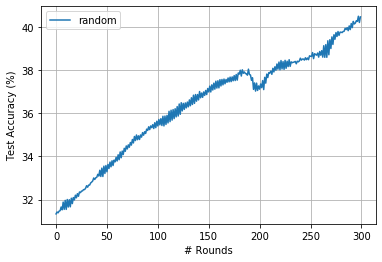

In [32]:
plt.plot(acc_test_arr2[0,0,:], label='random')
# plt.plot(acc_test_arr_partition[:], label='partition')
# plt.plot(acc_test_arr_Proposed_N40_K8_T4[:], label='proposed, T=4')
# plt.plot(acc_test_arr_Proposed_N40_K8_T2[:], label='proposed, T=2')
# plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

# 2. N=40

In [86]:
# load dataset and split users
args.num_users = 100
num_class_per_user = 1

from torchvision import datasets, transforms

trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)

# dict_users = cifar_iid(dataset_train, args.num_users)
dict_users = cifar_noniid(dataset_train, args.num_users, num_class_per_user)

Files already downloaded and verified
Files already downloaded and verified


In [93]:
from models.Nets import NIN,CNN_moderate, CNN_moderate_wDrop, CNNCifar3

p = 0.3
N = 100
K = 10

N_trials = 1
Max_iter = 1000



args.opt = 'SGD'

lr_array = [0.03, 0.05, 0.01, 0.005, 0.001]

args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

acc_test_arr_v1  = np.zeros((len(lr_array),N_trials,Max_iter))
loss_test_arr_v1 = np.zeros((len(lr_array),N_trials,Max_iter))

P_random = []

for lr_idx in range(len(lr_array)):
    
    args.lr       = lr_array[lr_idx]
    
    for trial_idx in range(N_trials):

        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []

    #         u = np.random.binomial(1, 1-p, size=(N))

    #         result = np.where(u == 1)

    #         ###############################
    #         # 1. Random Selection
    #         ###############################
    # #         idxs_users = np.random.choice(result[0], K, replace=False)
    #         idxs_users = np.random.choice(range(N), K, replace=False)

    #         p_tmp = np.zeros(N)
    #         p_tmp[idxs_users] = 1

    #         P_random.append(p_tmp)

            idxs_users = np.random.choice(range(N), K, replace=False)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

            #loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_v1[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_v1[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Test set: Average loss: 2.5029 
Accuracy: 1000/10000 (10.00%)

Round   0, Train average loss 1.339 Test accuracy 10.000

Test set: Average loss: 2.5678 
Accuracy: 1131/10000 (11.31%)

Round   1, Train average loss 0.294 Test accuracy 11.310

Test set: Average loss: 2.5199 
Accuracy: 1014/10000 (10.14%)

Round   2, Train average loss 0.321 Test accuracy 10.140

Test set: Average loss: 3.1779 
Accuracy: 1000/10000 (10.00%)

Round   3, Train average loss 0.454 Test accuracy 10.000

Test set: Average loss: 2.6237 
Accuracy: 1000/10000 (10.00%)

Round   4


Test set: Average loss: 2.7096 
Accuracy: 1000/10000 (10.00%)

Round  65, Train average loss 0.507 Test accuracy 10.000

Test set: Average loss: 2.4947 
Accuracy: 1168/10000 (11.68%)

Round  66, Train average loss 0.461 Test accuracy 11.680

Test set: Average loss: 2.5331 
Accuracy: 1083/10000 (10.83%)

Round  67, Train average loss 0.361 Test accuracy 10.830

Test set: Average loss: 2.4453 
Accuracy: 1004/10000 (10.04%)

Round  68, Train average loss 0.343 Test accuracy 10.040

Test set: Average loss: 2.5611 
Accuracy: 1000/10000 (10.00%)

Round  69, Train average loss 0.359 Test accuracy 10.000

Test set: Average loss: 2.6733 
Accuracy: 1019/10000 (10.19%)

Round  70, Train average loss 0.292 Test accuracy 10.190

Test set: Average loss: 2.5507 
Accuracy: 999/10000 (9.99%)

Round  71, Train average loss 0.275 Test accuracy 9.990

Test set: Average loss: 2.6994 
Accuracy: 1000/10000 (10.00%)

Round  72, Train average loss 0.359 Test accuracy 10.000

Test set: Average loss: 2.6154 
Ac


Test set: Average loss: 2.2039 
Accuracy: 1367/10000 (13.67%)

Round 133, Train average loss 0.331 Test accuracy 13.670

Test set: Average loss: 2.2538 
Accuracy: 1334/10000 (13.34%)

Round 134, Train average loss 0.263 Test accuracy 13.340

Test set: Average loss: 3.0825 
Accuracy: 1032/10000 (10.32%)

Round 135, Train average loss 0.232 Test accuracy 10.320

Test set: Average loss: 2.3681 
Accuracy: 1480/10000 (14.80%)

Round 136, Train average loss 0.444 Test accuracy 14.800

Test set: Average loss: 2.6776 
Accuracy: 1237/10000 (12.37%)

Round 137, Train average loss 0.386 Test accuracy 12.370

Test set: Average loss: 2.3276 
Accuracy: 1709/10000 (17.09%)

Round 138, Train average loss 0.357 Test accuracy 17.090

Test set: Average loss: 2.2379 
Accuracy: 1348/10000 (13.48%)

Round 139, Train average loss 0.434 Test accuracy 13.480

Test set: Average loss: 2.3909 
Accuracy: 1751/10000 (17.51%)

Round 140, Train average loss 0.279 Test accuracy 17.510

Test set: Average loss: 2.4006 


Test set: Average loss: 2.5409 
Accuracy: 1139/10000 (11.39%)

Round 201, Train average loss 0.228 Test accuracy 11.390

Test set: Average loss: 2.4408 
Accuracy: 1465/10000 (14.65%)

Round 202, Train average loss 0.211 Test accuracy 14.650

Test set: Average loss: 2.3079 
Accuracy: 1655/10000 (16.55%)

Round 203, Train average loss 0.350 Test accuracy 16.550

Test set: Average loss: 2.9281 
Accuracy: 1096/10000 (10.96%)

Round 204, Train average loss 0.303 Test accuracy 10.960

Test set: Average loss: 2.3949 
Accuracy: 1713/10000 (17.13%)

Round 205, Train average loss 0.375 Test accuracy 17.130

Test set: Average loss: 2.5469 
Accuracy: 1279/10000 (12.79%)

Round 206, Train average loss 0.337 Test accuracy 12.790

Test set: Average loss: 2.2585 
Accuracy: 1740/10000 (17.40%)

Round 207, Train average loss 0.450 Test accuracy 17.400

Test set: Average loss: 2.3930 
Accuracy: 1531/10000 (15.31%)

Round 208, Train average loss 0.293 Test accuracy 15.310

Test set: Average loss: 2.2181 


Test set: Average loss: 2.8508 
Accuracy: 1234/10000 (12.34%)

Round 269, Train average loss 0.231 Test accuracy 12.340

Test set: Average loss: 2.6143 
Accuracy: 1275/10000 (12.75%)

Round 270, Train average loss 0.370 Test accuracy 12.750

Test set: Average loss: 2.3966 
Accuracy: 1616/10000 (16.16%)

Round 271, Train average loss 0.514 Test accuracy 16.160

Test set: Average loss: 2.3237 
Accuracy: 1478/10000 (14.78%)

Round 272, Train average loss 0.349 Test accuracy 14.780

Test set: Average loss: 2.4694 
Accuracy: 1294/10000 (12.94%)

Round 273, Train average loss 0.290 Test accuracy 12.940

Test set: Average loss: 2.4769 
Accuracy: 1638/10000 (16.38%)

Round 274, Train average loss 0.274 Test accuracy 16.380

Test set: Average loss: 2.5495 
Accuracy: 1272/10000 (12.72%)

Round 275, Train average loss 0.334 Test accuracy 12.720

Test set: Average loss: 2.0962 
Accuracy: 2216/10000 (22.16%)

Round 276, Train average loss 0.417 Test accuracy 22.160

Test set: Average loss: 2.1423 


Test set: Average loss: 2.3670 
Accuracy: 1665/10000 (16.65%)

Round 337, Train average loss 0.343 Test accuracy 16.650

Test set: Average loss: 2.1892 
Accuracy: 1931/10000 (19.31%)

Round 338, Train average loss 0.303 Test accuracy 19.310

Test set: Average loss: 2.1305 
Accuracy: 2279/10000 (22.79%)

Round 339, Train average loss 0.293 Test accuracy 22.790

Test set: Average loss: 2.3008 
Accuracy: 1659/10000 (16.59%)

Round 340, Train average loss 0.206 Test accuracy 16.590

Test set: Average loss: 2.3394 
Accuracy: 1588/10000 (15.88%)

Round 341, Train average loss 0.252 Test accuracy 15.880

Test set: Average loss: 2.0367 
Accuracy: 1874/10000 (18.74%)

Round 342, Train average loss 0.313 Test accuracy 18.740

Test set: Average loss: 2.1252 
Accuracy: 1748/10000 (17.48%)

Round 343, Train average loss 0.241 Test accuracy 17.480

Test set: Average loss: 2.4697 
Accuracy: 1403/10000 (14.03%)

Round 344, Train average loss 0.266 Test accuracy 14.030

Test set: Average loss: 2.3555 


Test set: Average loss: 2.4121 
Accuracy: 1689/10000 (16.89%)

Round 405, Train average loss 0.412 Test accuracy 16.890

Test set: Average loss: 2.5433 
Accuracy: 1307/10000 (13.07%)

Round 406, Train average loss 0.359 Test accuracy 13.070

Test set: Average loss: 2.1697 
Accuracy: 1810/10000 (18.10%)

Round 407, Train average loss 0.364 Test accuracy 18.100

Test set: Average loss: 2.3018 
Accuracy: 1556/10000 (15.56%)

Round 408, Train average loss 0.351 Test accuracy 15.560

Test set: Average loss: 2.1387 
Accuracy: 1848/10000 (18.48%)

Round 409, Train average loss 0.276 Test accuracy 18.480

Test set: Average loss: 2.1751 
Accuracy: 1998/10000 (19.98%)

Round 410, Train average loss 0.211 Test accuracy 19.980

Test set: Average loss: 2.4395 
Accuracy: 1761/10000 (17.61%)

Round 411, Train average loss 0.206 Test accuracy 17.610

Test set: Average loss: 2.2082 
Accuracy: 2011/10000 (20.11%)

Round 412, Train average loss 0.278 Test accuracy 20.110

Test set: Average loss: 2.1795 


Test set: Average loss: 2.1930 
Accuracy: 1656/10000 (16.56%)

Round 473, Train average loss 0.231 Test accuracy 16.560

Test set: Average loss: 2.4221 
Accuracy: 1644/10000 (16.44%)

Round 474, Train average loss 0.329 Test accuracy 16.440

Test set: Average loss: 2.0774 
Accuracy: 1884/10000 (18.84%)

Round 475, Train average loss 0.316 Test accuracy 18.840

Test set: Average loss: 2.1960 
Accuracy: 1843/10000 (18.43%)

Round 476, Train average loss 0.228 Test accuracy 18.430

Test set: Average loss: 2.3381 
Accuracy: 1745/10000 (17.45%)

Round 477, Train average loss 0.261 Test accuracy 17.450

Test set: Average loss: 2.0661 
Accuracy: 2076/10000 (20.76%)

Round 478, Train average loss 0.332 Test accuracy 20.760

Test set: Average loss: 1.9483 
Accuracy: 2500/10000 (25.00%)

Round 479, Train average loss 0.266 Test accuracy 25.000

Test set: Average loss: 2.2543 
Accuracy: 1934/10000 (19.34%)

Round 480, Train average loss 0.220 Test accuracy 19.340

Test set: Average loss: 2.0128 


Test set: Average loss: 1.9818 
Accuracy: 2249/10000 (22.49%)

Round 541, Train average loss 0.246 Test accuracy 22.490

Test set: Average loss: 2.1645 
Accuracy: 2015/10000 (20.15%)

Round 542, Train average loss 0.257 Test accuracy 20.150

Test set: Average loss: 1.9234 
Accuracy: 2790/10000 (27.90%)

Round 543, Train average loss 0.271 Test accuracy 27.900

Test set: Average loss: 2.2532 
Accuracy: 2187/10000 (21.87%)

Round 544, Train average loss 0.208 Test accuracy 21.870

Test set: Average loss: 2.0491 
Accuracy: 2448/10000 (24.48%)

Round 545, Train average loss 0.261 Test accuracy 24.480

Test set: Average loss: 1.8688 
Accuracy: 2986/10000 (29.86%)

Round 546, Train average loss 0.242 Test accuracy 29.860

Test set: Average loss: 1.8951 
Accuracy: 2527/10000 (25.27%)

Round 547, Train average loss 0.196 Test accuracy 25.270

Test set: Average loss: 2.0681 
Accuracy: 1900/10000 (19.00%)

Round 548, Train average loss 0.204 Test accuracy 19.000

Test set: Average loss: 2.0640 


Test set: Average loss: 1.8793 
Accuracy: 2745/10000 (27.45%)

Round 609, Train average loss 0.279 Test accuracy 27.450

Test set: Average loss: 1.8119 
Accuracy: 3109/10000 (31.09%)

Round 610, Train average loss 0.235 Test accuracy 31.090

Test set: Average loss: 1.9640 
Accuracy: 2720/10000 (27.20%)

Round 611, Train average loss 0.218 Test accuracy 27.200

Test set: Average loss: 2.0152 
Accuracy: 2645/10000 (26.45%)

Round 612, Train average loss 0.230 Test accuracy 26.450

Test set: Average loss: 1.9106 
Accuracy: 2790/10000 (27.90%)

Round 613, Train average loss 0.229 Test accuracy 27.900

Test set: Average loss: 1.9911 
Accuracy: 2849/10000 (28.49%)

Round 614, Train average loss 0.214 Test accuracy 28.490

Test set: Average loss: 1.8593 
Accuracy: 3038/10000 (30.38%)

Round 615, Train average loss 0.249 Test accuracy 30.380

Test set: Average loss: 2.2283 
Accuracy: 2090/10000 (20.90%)

Round 616, Train average loss 0.259 Test accuracy 20.900

Test set: Average loss: 1.8070 


Test set: Average loss: 1.9502 
Accuracy: 2609/10000 (26.09%)

Round 677, Train average loss 0.266 Test accuracy 26.090

Test set: Average loss: 1.9442 
Accuracy: 2829/10000 (28.29%)

Round 678, Train average loss 0.167 Test accuracy 28.290

Test set: Average loss: 1.9614 
Accuracy: 2493/10000 (24.93%)

Round 679, Train average loss 0.229 Test accuracy 24.930

Test set: Average loss: 2.2725 
Accuracy: 2356/10000 (23.56%)

Round 680, Train average loss 0.212 Test accuracy 23.560

Test set: Average loss: 2.4116 
Accuracy: 2027/10000 (20.27%)

Round 681, Train average loss 0.239 Test accuracy 20.270

Test set: Average loss: 2.7028 
Accuracy: 1546/10000 (15.46%)

Round 682, Train average loss 0.275 Test accuracy 15.460

Test set: Average loss: 2.0753 
Accuracy: 2646/10000 (26.46%)

Round 683, Train average loss 0.282 Test accuracy 26.460

Test set: Average loss: 2.1320 
Accuracy: 2092/10000 (20.92%)

Round 684, Train average loss 0.267 Test accuracy 20.920

Test set: Average loss: 1.9735 


Test set: Average loss: 2.0941 
Accuracy: 2262/10000 (22.62%)

Round 745, Train average loss 0.207 Test accuracy 22.620

Test set: Average loss: 2.2060 
Accuracy: 2147/10000 (21.47%)

Round 746, Train average loss 0.214 Test accuracy 21.470

Test set: Average loss: 2.2872 
Accuracy: 1915/10000 (19.15%)

Round 747, Train average loss 0.264 Test accuracy 19.150

Test set: Average loss: 2.3522 
Accuracy: 1699/10000 (16.99%)

Round 748, Train average loss 0.339 Test accuracy 16.990

Test set: Average loss: 1.9471 
Accuracy: 2517/10000 (25.17%)

Round 749, Train average loss 0.273 Test accuracy 25.170

Test set: Average loss: 1.9032 
Accuracy: 2527/10000 (25.27%)

Round 750, Train average loss 0.234 Test accuracy 25.270

Test set: Average loss: 1.7163 
Accuracy: 3608/10000 (36.08%)

Round 751, Train average loss 0.253 Test accuracy 36.080

Test set: Average loss: 2.3802 
Accuracy: 1450/10000 (14.50%)

Round 752, Train average loss 0.207 Test accuracy 14.500

Test set: Average loss: 1.8507 


Test set: Average loss: 1.9350 
Accuracy: 2688/10000 (26.88%)

Round 813, Train average loss 0.181 Test accuracy 26.880

Test set: Average loss: 1.8653 
Accuracy: 2788/10000 (27.88%)

Round 814, Train average loss 0.250 Test accuracy 27.880

Test set: Average loss: 1.7359 
Accuracy: 3288/10000 (32.88%)

Round 815, Train average loss 0.234 Test accuracy 32.880

Test set: Average loss: 1.6641 
Accuracy: 3713/10000 (37.13%)

Round 816, Train average loss 0.209 Test accuracy 37.130

Test set: Average loss: 1.9150 
Accuracy: 3013/10000 (30.13%)

Round 817, Train average loss 0.194 Test accuracy 30.130

Test set: Average loss: 2.0381 
Accuracy: 2736/10000 (27.36%)

Round 818, Train average loss 0.255 Test accuracy 27.360

Test set: Average loss: 1.7132 
Accuracy: 3487/10000 (34.87%)

Round 819, Train average loss 0.268 Test accuracy 34.870

Test set: Average loss: 2.0766 
Accuracy: 2474/10000 (24.74%)

Round 820, Train average loss 0.206 Test accuracy 24.740

Test set: Average loss: 1.8566 


Test set: Average loss: 1.7233 
Accuracy: 3705/10000 (37.05%)

Round 881, Train average loss 0.191 Test accuracy 37.050

Test set: Average loss: 1.9317 
Accuracy: 2987/10000 (29.87%)

Round 882, Train average loss 0.214 Test accuracy 29.870

Test set: Average loss: 1.6292 
Accuracy: 4038/10000 (40.38%)

Round 883, Train average loss 0.207 Test accuracy 40.380

Test set: Average loss: 1.8521 
Accuracy: 3034/10000 (30.34%)

Round 884, Train average loss 0.191 Test accuracy 30.340

Test set: Average loss: 1.8064 
Accuracy: 3517/10000 (35.17%)

Round 885, Train average loss 0.188 Test accuracy 35.170

Test set: Average loss: 2.1494 
Accuracy: 2469/10000 (24.69%)

Round 886, Train average loss 0.241 Test accuracy 24.690

Test set: Average loss: 1.7759 
Accuracy: 3508/10000 (35.08%)

Round 887, Train average loss 0.248 Test accuracy 35.080

Test set: Average loss: 1.7544 
Accuracy: 3284/10000 (32.84%)

Round 888, Train average loss 0.202 Test accuracy 32.840

Test set: Average loss: 1.7552 


Test set: Average loss: 1.7951 
Accuracy: 3230/10000 (32.30%)

Round 949, Train average loss 0.209 Test accuracy 32.300

Test set: Average loss: 1.9015 
Accuracy: 2899/10000 (28.99%)

Round 950, Train average loss 0.168 Test accuracy 28.990

Test set: Average loss: 1.7176 
Accuracy: 3753/10000 (37.53%)

Round 951, Train average loss 0.179 Test accuracy 37.530

Test set: Average loss: 1.7147 
Accuracy: 3578/10000 (35.78%)

Round 952, Train average loss 0.183 Test accuracy 35.780

Test set: Average loss: 1.8112 
Accuracy: 3480/10000 (34.80%)

Round 953, Train average loss 0.165 Test accuracy 34.800

Test set: Average loss: 1.8647 
Accuracy: 3377/10000 (33.77%)

Round 954, Train average loss 0.163 Test accuracy 33.770

Test set: Average loss: 1.9080 
Accuracy: 2686/10000 (26.86%)

Round 955, Train average loss 0.224 Test accuracy 26.860

Test set: Average loss: 1.9214 
Accuracy: 2919/10000 (29.19%)

Round 956, Train average loss 0.226 Test accuracy 29.190

Test set: Average loss: 1.6436 


Test set: Average loss: 2.3791 
Accuracy: 1000/10000 (10.00%)

Round  14, Train average loss 0.707 Test accuracy 10.000

Test set: Average loss: 2.5258 
Accuracy: 964/10000 (9.64%)

Round  15, Train average loss 0.496 Test accuracy 9.640

Test set: Average loss: 2.7521 
Accuracy: 1000/10000 (10.00%)

Round  16, Train average loss 0.270 Test accuracy 10.000

Test set: Average loss: 3.2741 
Accuracy: 1000/10000 (10.00%)

Round  17, Train average loss 0.384 Test accuracy 10.000

Test set: Average loss: 3.0072 
Accuracy: 1000/10000 (10.00%)

Round  18, Train average loss 0.595 Test accuracy 10.000

Test set: Average loss: 2.4853 
Accuracy: 1000/10000 (10.00%)

Round  19, Train average loss 0.612 Test accuracy 10.000

Test set: Average loss: 2.7190 
Accuracy: 1047/10000 (10.47%)

Round  20, Train average loss 0.630 Test accuracy 10.470

Test set: Average loss: 4.8464 
Accuracy: 1000/10000 (10.00%)

Round  21, Train average loss 0.587 Test accuracy 10.000

Test set: Average loss: 3.3635 
Ac


Test set: Average loss: 2.2497 
Accuracy: 1611/10000 (16.11%)

Round  82, Train average loss 0.379 Test accuracy 16.110

Test set: Average loss: 3.1884 
Accuracy: 1562/10000 (15.62%)

Round  83, Train average loss 0.409 Test accuracy 15.620

Test set: Average loss: 2.4360 
Accuracy: 1000/10000 (10.00%)

Round  84, Train average loss 0.452 Test accuracy 10.000

Test set: Average loss: 2.5194 
Accuracy: 1138/10000 (11.38%)

Round  85, Train average loss 0.344 Test accuracy 11.380

Test set: Average loss: 2.6517 
Accuracy: 1285/10000 (12.85%)

Round  86, Train average loss 0.344 Test accuracy 12.850

Test set: Average loss: 2.3716 
Accuracy: 1731/10000 (17.31%)

Round  87, Train average loss 0.468 Test accuracy 17.310

Test set: Average loss: 2.9060 
Accuracy: 998/10000 (9.98%)

Round  88, Train average loss 0.391 Test accuracy 9.980

Test set: Average loss: 2.5445 
Accuracy: 1041/10000 (10.41%)

Round  89, Train average loss 0.446 Test accuracy 10.410

Test set: Average loss: 3.5983 
Ac


Test set: Average loss: 2.5480 
Accuracy: 1104/10000 (11.04%)

Round 150, Train average loss 0.278 Test accuracy 11.040

Test set: Average loss: 2.4655 
Accuracy: 1001/10000 (10.01%)

Round 151, Train average loss 0.326 Test accuracy 10.010

Test set: Average loss: 2.5387 
Accuracy: 1000/10000 (10.00%)

Round 152, Train average loss 0.304 Test accuracy 10.000

Test set: Average loss: 2.4169 
Accuracy: 1001/10000 (10.01%)

Round 153, Train average loss 0.264 Test accuracy 10.010

Test set: Average loss: 2.5502 
Accuracy: 1206/10000 (12.06%)

Round 154, Train average loss 0.330 Test accuracy 12.060

Test set: Average loss: 2.4493 
Accuracy: 1483/10000 (14.83%)

Round 155, Train average loss 0.321 Test accuracy 14.830

Test set: Average loss: 2.3214 
Accuracy: 1669/10000 (16.69%)

Round 156, Train average loss 0.353 Test accuracy 16.690

Test set: Average loss: 2.4020 
Accuracy: 1507/10000 (15.07%)

Round 157, Train average loss 0.276 Test accuracy 15.070

Test set: Average loss: 2.8364 


Test set: Average loss: 2.9197 
Accuracy: 1000/10000 (10.00%)

Round 218, Train average loss 0.378 Test accuracy 10.000

Test set: Average loss: 2.6247 
Accuracy: 1000/10000 (10.00%)

Round 219, Train average loss 0.437 Test accuracy 10.000

Test set: Average loss: 2.2764 
Accuracy: 1420/10000 (14.20%)

Round 220, Train average loss 0.366 Test accuracy 14.200

Test set: Average loss: 2.4466 
Accuracy: 1569/10000 (15.69%)

Round 221, Train average loss 0.327 Test accuracy 15.690

Test set: Average loss: 2.3829 
Accuracy: 1377/10000 (13.77%)

Round 222, Train average loss 0.430 Test accuracy 13.770

Test set: Average loss: 2.2323 
Accuracy: 1745/10000 (17.45%)

Round 223, Train average loss 0.339 Test accuracy 17.450

Test set: Average loss: 2.1783 
Accuracy: 1889/10000 (18.89%)

Round 224, Train average loss 0.317 Test accuracy 18.890

Test set: Average loss: 2.2425 
Accuracy: 1936/10000 (19.36%)

Round 225, Train average loss 0.237 Test accuracy 19.360

Test set: Average loss: 2.3646 


Test set: Average loss: 2.5955 
Accuracy: 1019/10000 (10.19%)

Round 286, Train average loss 0.353 Test accuracy 10.190

Test set: Average loss: 2.3449 
Accuracy: 1075/10000 (10.75%)

Round 287, Train average loss 0.431 Test accuracy 10.750

Test set: Average loss: 2.3601 
Accuracy: 1127/10000 (11.27%)

Round 288, Train average loss 0.320 Test accuracy 11.270

Test set: Average loss: 2.6448 
Accuracy: 1151/10000 (11.51%)

Round 289, Train average loss 0.234 Test accuracy 11.510

Test set: Average loss: 2.6693 
Accuracy: 1015/10000 (10.15%)

Round 290, Train average loss 0.329 Test accuracy 10.150

Test set: Average loss: 2.4639 
Accuracy: 1186/10000 (11.86%)

Round 291, Train average loss 0.352 Test accuracy 11.860

Test set: Average loss: 2.4578 
Accuracy: 1240/10000 (12.40%)

Round 292, Train average loss 0.396 Test accuracy 12.400

Test set: Average loss: 2.5267 
Accuracy: 999/10000 (9.99%)

Round 293, Train average loss 0.270 Test accuracy 9.990

Test set: Average loss: 2.7334 
Ac


Test set: Average loss: 2.2944 
Accuracy: 1543/10000 (15.43%)

Round 354, Train average loss 0.291 Test accuracy 15.430

Test set: Average loss: 2.1768 
Accuracy: 1806/10000 (18.06%)

Round 355, Train average loss 0.261 Test accuracy 18.060

Test set: Average loss: 2.1880 
Accuracy: 2293/10000 (22.93%)

Round 356, Train average loss 0.291 Test accuracy 22.930

Test set: Average loss: 2.0876 
Accuracy: 1900/10000 (19.00%)

Round 357, Train average loss 0.270 Test accuracy 19.000

Test set: Average loss: 2.2715 
Accuracy: 1666/10000 (16.66%)

Round 358, Train average loss 0.255 Test accuracy 16.660

Test set: Average loss: 2.2085 
Accuracy: 2027/10000 (20.27%)

Round 359, Train average loss 0.269 Test accuracy 20.270

Test set: Average loss: 2.1641 
Accuracy: 1961/10000 (19.61%)

Round 360, Train average loss 0.243 Test accuracy 19.610

Test set: Average loss: 2.2049 
Accuracy: 1933/10000 (19.33%)

Round 361, Train average loss 0.228 Test accuracy 19.330

Test set: Average loss: 2.1816 


Test set: Average loss: 2.0671 
Accuracy: 1904/10000 (19.04%)

Round 422, Train average loss 0.316 Test accuracy 19.040

Test set: Average loss: 2.1312 
Accuracy: 2249/10000 (22.49%)

Round 423, Train average loss 0.240 Test accuracy 22.490

Test set: Average loss: 2.4417 
Accuracy: 1459/10000 (14.59%)

Round 424, Train average loss 0.297 Test accuracy 14.590

Test set: Average loss: 2.1594 
Accuracy: 2030/10000 (20.30%)

Round 425, Train average loss 0.275 Test accuracy 20.300

Test set: Average loss: 2.2787 
Accuracy: 1823/10000 (18.23%)

Round 426, Train average loss 0.265 Test accuracy 18.230

Test set: Average loss: 2.2083 
Accuracy: 1339/10000 (13.39%)

Round 427, Train average loss 0.275 Test accuracy 13.390

Test set: Average loss: 3.1795 
Accuracy: 1276/10000 (12.76%)

Round 428, Train average loss 0.284 Test accuracy 12.760

Test set: Average loss: 2.4959 
Accuracy: 1064/10000 (10.64%)

Round 429, Train average loss 0.449 Test accuracy 10.640

Test set: Average loss: 2.3390 


Test set: Average loss: 2.3278 
Accuracy: 1444/10000 (14.44%)

Round 490, Train average loss 0.251 Test accuracy 14.440

Test set: Average loss: 2.1597 
Accuracy: 1993/10000 (19.93%)

Round 491, Train average loss 0.254 Test accuracy 19.930

Test set: Average loss: 2.4009 
Accuracy: 1502/10000 (15.02%)

Round 492, Train average loss 0.290 Test accuracy 15.020

Test set: Average loss: 2.3380 
Accuracy: 1820/10000 (18.20%)

Round 493, Train average loss 0.258 Test accuracy 18.200

Test set: Average loss: 2.1775 
Accuracy: 1722/10000 (17.22%)

Round 494, Train average loss 0.260 Test accuracy 17.220

Test set: Average loss: 3.0207 
Accuracy: 1039/10000 (10.39%)

Round 495, Train average loss 0.260 Test accuracy 10.390

Test set: Average loss: 2.7080 
Accuracy: 1425/10000 (14.25%)

Round 496, Train average loss 0.335 Test accuracy 14.250

Test set: Average loss: 2.6544 
Accuracy: 1296/10000 (12.96%)

Round 497, Train average loss 0.419 Test accuracy 12.960

Test set: Average loss: 2.3092 


Test set: Average loss: 2.5648 
Accuracy: 1772/10000 (17.72%)

Round 558, Train average loss 0.271 Test accuracy 17.720

Test set: Average loss: 2.1898 
Accuracy: 1924/10000 (19.24%)

Round 559, Train average loss 0.350 Test accuracy 19.240

Test set: Average loss: 2.2625 
Accuracy: 1708/10000 (17.08%)

Round 560, Train average loss 0.228 Test accuracy 17.080

Test set: Average loss: 2.2226 
Accuracy: 1827/10000 (18.27%)

Round 561, Train average loss 0.250 Test accuracy 18.270

Test set: Average loss: 2.1746 
Accuracy: 2140/10000 (21.40%)

Round 562, Train average loss 0.278 Test accuracy 21.400

Test set: Average loss: 2.2442 
Accuracy: 1431/10000 (14.31%)

Round 563, Train average loss 0.294 Test accuracy 14.310

Test set: Average loss: 2.7193 
Accuracy: 1440/10000 (14.40%)

Round 564, Train average loss 0.302 Test accuracy 14.400

Test set: Average loss: 2.1901 
Accuracy: 2303/10000 (23.03%)

Round 565, Train average loss 0.349 Test accuracy 23.030

Test set: Average loss: 2.4693 


Test set: Average loss: 1.9743 
Accuracy: 2629/10000 (26.29%)

Round 626, Train average loss 0.261 Test accuracy 26.290

Test set: Average loss: 2.2469 
Accuracy: 1698/10000 (16.98%)

Round 627, Train average loss 0.211 Test accuracy 16.980

Test set: Average loss: 2.1325 
Accuracy: 2390/10000 (23.90%)

Round 628, Train average loss 0.286 Test accuracy 23.900

Test set: Average loss: 2.1959 
Accuracy: 1986/10000 (19.86%)

Round 629, Train average loss 0.240 Test accuracy 19.860

Test set: Average loss: 2.3323 
Accuracy: 1647/10000 (16.47%)

Round 630, Train average loss 0.328 Test accuracy 16.470

Test set: Average loss: 2.0029 
Accuracy: 2151/10000 (21.51%)

Round 631, Train average loss 0.274 Test accuracy 21.510

Test set: Average loss: 2.1804 
Accuracy: 2268/10000 (22.68%)

Round 632, Train average loss 0.258 Test accuracy 22.680

Test set: Average loss: 1.9386 
Accuracy: 2797/10000 (27.97%)

Round 633, Train average loss 0.237 Test accuracy 27.970

Test set: Average loss: 1.9978 


Test set: Average loss: 1.9171 
Accuracy: 3094/10000 (30.94%)

Round 694, Train average loss 0.237 Test accuracy 30.940

Test set: Average loss: 1.9767 
Accuracy: 2442/10000 (24.42%)

Round 695, Train average loss 0.198 Test accuracy 24.420

Test set: Average loss: 2.1733 
Accuracy: 1782/10000 (17.82%)

Round 696, Train average loss 0.233 Test accuracy 17.820

Test set: Average loss: 2.1118 
Accuracy: 2102/10000 (21.02%)

Round 697, Train average loss 0.329 Test accuracy 21.020

Test set: Average loss: 1.8948 
Accuracy: 2515/10000 (25.15%)

Round 698, Train average loss 0.222 Test accuracy 25.150

Test set: Average loss: 2.1201 
Accuracy: 1951/10000 (19.51%)

Round 699, Train average loss 0.238 Test accuracy 19.510

Test set: Average loss: 2.0717 
Accuracy: 2199/10000 (21.99%)

Round 700, Train average loss 0.234 Test accuracy 21.990

Test set: Average loss: 2.2680 
Accuracy: 2003/10000 (20.03%)

Round 701, Train average loss 0.300 Test accuracy 20.030

Test set: Average loss: 2.1902 


Test set: Average loss: 2.5784 
Accuracy: 1626/10000 (16.26%)

Round 762, Train average loss 0.247 Test accuracy 16.260

Test set: Average loss: 2.4106 
Accuracy: 1830/10000 (18.30%)

Round 763, Train average loss 0.318 Test accuracy 18.300

Test set: Average loss: 1.9926 
Accuracy: 2641/10000 (26.41%)

Round 764, Train average loss 0.346 Test accuracy 26.410

Test set: Average loss: 2.1921 
Accuracy: 1739/10000 (17.39%)

Round 765, Train average loss 0.302 Test accuracy 17.390

Test set: Average loss: 1.8782 
Accuracy: 2963/10000 (29.63%)

Round 766, Train average loss 0.272 Test accuracy 29.630

Test set: Average loss: 1.8679 
Accuracy: 3058/10000 (30.58%)

Round 767, Train average loss 0.218 Test accuracy 30.580

Test set: Average loss: 2.4241 
Accuracy: 1282/10000 (12.82%)

Round 768, Train average loss 0.255 Test accuracy 12.820

Test set: Average loss: 2.5083 
Accuracy: 1639/10000 (16.39%)

Round 769, Train average loss 0.308 Test accuracy 16.390

Test set: Average loss: 2.0435 


Test set: Average loss: 2.0477 
Accuracy: 2557/10000 (25.57%)

Round 830, Train average loss 0.221 Test accuracy 25.570

Test set: Average loss: 1.9277 
Accuracy: 2697/10000 (26.97%)

Round 831, Train average loss 0.246 Test accuracy 26.970

Test set: Average loss: 1.9253 
Accuracy: 2420/10000 (24.20%)

Round 832, Train average loss 0.221 Test accuracy 24.200

Test set: Average loss: 2.0703 
Accuracy: 2213/10000 (22.13%)

Round 833, Train average loss 0.199 Test accuracy 22.130

Test set: Average loss: 1.9836 
Accuracy: 2498/10000 (24.98%)

Round 834, Train average loss 0.232 Test accuracy 24.980

Test set: Average loss: 2.4663 
Accuracy: 1861/10000 (18.61%)

Round 835, Train average loss 0.255 Test accuracy 18.610

Test set: Average loss: 2.0801 
Accuracy: 2165/10000 (21.65%)

Round 836, Train average loss 0.304 Test accuracy 21.650

Test set: Average loss: 2.0042 
Accuracy: 2428/10000 (24.28%)

Round 837, Train average loss 0.261 Test accuracy 24.280

Test set: Average loss: 2.0670 


Test set: Average loss: 1.8278 
Accuracy: 2835/10000 (28.35%)

Round 898, Train average loss 0.250 Test accuracy 28.350

Test set: Average loss: 1.9043 
Accuracy: 3271/10000 (32.71%)

Round 899, Train average loss 0.189 Test accuracy 32.710

Test set: Average loss: 1.9172 
Accuracy: 2766/10000 (27.66%)

Round 900, Train average loss 0.224 Test accuracy 27.660

Test set: Average loss: 1.8473 
Accuracy: 3085/10000 (30.85%)

Round 901, Train average loss 0.216 Test accuracy 30.850

Test set: Average loss: 1.8266 
Accuracy: 3077/10000 (30.77%)

Round 902, Train average loss 0.214 Test accuracy 30.770

Test set: Average loss: 2.3184 
Accuracy: 2252/10000 (22.52%)

Round 903, Train average loss 0.180 Test accuracy 22.520

Test set: Average loss: 2.1261 
Accuracy: 2468/10000 (24.68%)

Round 904, Train average loss 0.299 Test accuracy 24.680

Test set: Average loss: 2.0640 
Accuracy: 2077/10000 (20.77%)

Round 905, Train average loss 0.228 Test accuracy 20.770

Test set: Average loss: 2.1601 


Test set: Average loss: 1.8832 
Accuracy: 3012/10000 (30.12%)

Round 966, Train average loss 0.246 Test accuracy 30.120

Test set: Average loss: 2.1250 
Accuracy: 2371/10000 (23.71%)

Round 967, Train average loss 0.180 Test accuracy 23.710

Test set: Average loss: 2.6790 
Accuracy: 1816/10000 (18.16%)

Round 968, Train average loss 0.187 Test accuracy 18.160

Test set: Average loss: 2.0702 
Accuracy: 2052/10000 (20.52%)

Round 969, Train average loss 0.284 Test accuracy 20.520

Test set: Average loss: 2.4535 
Accuracy: 1622/10000 (16.22%)

Round 970, Train average loss 0.222 Test accuracy 16.220

Test set: Average loss: 2.2664 
Accuracy: 1650/10000 (16.50%)

Round 971, Train average loss 0.297 Test accuracy 16.500

Test set: Average loss: 1.9527 
Accuracy: 2941/10000 (29.41%)

Round 972, Train average loss 0.223 Test accuracy 29.410

Test set: Average loss: 1.8673 
Accuracy: 3037/10000 (30.37%)

Round 973, Train average loss 0.262 Test accuracy 30.370

Test set: Average loss: 2.1251 


Test set: Average loss: 2.4255 
Accuracy: 1001/10000 (10.01%)

Round  31, Train average loss 0.427 Test accuracy 10.010

Test set: Average loss: 2.5349 
Accuracy: 1108/10000 (11.08%)

Round  32, Train average loss 0.298 Test accuracy 11.080

Test set: Average loss: 2.2485 
Accuracy: 1702/10000 (17.02%)

Round  33, Train average loss 0.354 Test accuracy 17.020

Test set: Average loss: 2.5869 
Accuracy: 1000/10000 (10.00%)

Round  34, Train average loss 0.252 Test accuracy 10.000

Test set: Average loss: 2.3259 
Accuracy: 1089/10000 (10.89%)

Round  35, Train average loss 0.327 Test accuracy 10.890

Test set: Average loss: 2.4029 
Accuracy: 1000/10000 (10.00%)

Round  36, Train average loss 0.304 Test accuracy 10.000

Test set: Average loss: 2.6345 
Accuracy: 1438/10000 (14.38%)

Round  37, Train average loss 0.313 Test accuracy 14.380

Test set: Average loss: 2.6345 
Accuracy: 1000/10000 (10.00%)

Round  38, Train average loss 0.430 Test accuracy 10.000

Test set: Average loss: 2.5062 


Test set: Average loss: 2.6402 
Accuracy: 1231/10000 (12.31%)

Round  99, Train average loss 0.255 Test accuracy 12.310

Test set: Average loss: 2.3970 
Accuracy: 1342/10000 (13.42%)

Round 100, Train average loss 0.376 Test accuracy 13.420

Test set: Average loss: 2.2149 
Accuracy: 1910/10000 (19.10%)

Round 101, Train average loss 0.345 Test accuracy 19.100

Test set: Average loss: 2.2575 
Accuracy: 1810/10000 (18.10%)

Round 102, Train average loss 0.303 Test accuracy 18.100

Test set: Average loss: 2.2268 
Accuracy: 1752/10000 (17.52%)

Round 103, Train average loss 0.249 Test accuracy 17.520

Test set: Average loss: 2.3732 
Accuracy: 1624/10000 (16.24%)

Round 104, Train average loss 0.267 Test accuracy 16.240

Test set: Average loss: 2.2499 
Accuracy: 1838/10000 (18.38%)

Round 105, Train average loss 0.307 Test accuracy 18.380

Test set: Average loss: 2.3663 
Accuracy: 1278/10000 (12.78%)

Round 106, Train average loss 0.320 Test accuracy 12.780

Test set: Average loss: 2.8712 


Test set: Average loss: 2.1758 
Accuracy: 1788/10000 (17.88%)

Round 167, Train average loss 0.271 Test accuracy 17.880

Test set: Average loss: 2.2053 
Accuracy: 1314/10000 (13.14%)

Round 168, Train average loss 0.277 Test accuracy 13.140

Test set: Average loss: 2.2816 
Accuracy: 1658/10000 (16.58%)

Round 169, Train average loss 0.252 Test accuracy 16.580

Test set: Average loss: 2.1731 
Accuracy: 2042/10000 (20.42%)

Round 170, Train average loss 0.281 Test accuracy 20.420

Test set: Average loss: 2.1287 
Accuracy: 2294/10000 (22.94%)

Round 171, Train average loss 0.317 Test accuracy 22.940

Test set: Average loss: 2.1458 
Accuracy: 2238/10000 (22.38%)

Round 172, Train average loss 0.259 Test accuracy 22.380

Test set: Average loss: 2.0927 
Accuracy: 1745/10000 (17.45%)

Round 173, Train average loss 0.267 Test accuracy 17.450

Test set: Average loss: 2.1624 
Accuracy: 1888/10000 (18.88%)

Round 174, Train average loss 0.231 Test accuracy 18.880

Test set: Average loss: 2.1831 


Test set: Average loss: 2.2819 
Accuracy: 1612/10000 (16.12%)

Round 235, Train average loss 0.241 Test accuracy 16.120

Test set: Average loss: 2.2546 
Accuracy: 1276/10000 (12.76%)

Round 236, Train average loss 0.312 Test accuracy 12.760

Test set: Average loss: 2.1871 
Accuracy: 2112/10000 (21.12%)

Round 237, Train average loss 0.282 Test accuracy 21.120

Test set: Average loss: 2.0249 
Accuracy: 2516/10000 (25.16%)

Round 238, Train average loss 0.256 Test accuracy 25.160

Test set: Average loss: 2.0643 
Accuracy: 2157/10000 (21.57%)

Round 239, Train average loss 0.233 Test accuracy 21.570

Test set: Average loss: 2.1057 
Accuracy: 2195/10000 (21.95%)

Round 240, Train average loss 0.207 Test accuracy 21.950

Test set: Average loss: 2.1336 
Accuracy: 2042/10000 (20.42%)

Round 241, Train average loss 0.255 Test accuracy 20.420

Test set: Average loss: 2.3842 
Accuracy: 1670/10000 (16.70%)

Round 242, Train average loss 0.292 Test accuracy 16.700

Test set: Average loss: 2.0966 


Test set: Average loss: 2.1736 
Accuracy: 1921/10000 (19.21%)

Round 303, Train average loss 0.406 Test accuracy 19.210

Test set: Average loss: 2.1181 
Accuracy: 2024/10000 (20.24%)

Round 304, Train average loss 0.343 Test accuracy 20.240

Test set: Average loss: 2.1674 
Accuracy: 2035/10000 (20.35%)

Round 305, Train average loss 0.275 Test accuracy 20.350

Test set: Average loss: 2.1520 
Accuracy: 1925/10000 (19.25%)

Round 306, Train average loss 0.297 Test accuracy 19.250

Test set: Average loss: 2.0248 
Accuracy: 2313/10000 (23.13%)

Round 307, Train average loss 0.309 Test accuracy 23.130

Test set: Average loss: 2.2095 
Accuracy: 1676/10000 (16.76%)

Round 308, Train average loss 0.268 Test accuracy 16.760

Test set: Average loss: 1.9993 
Accuracy: 2544/10000 (25.44%)

Round 309, Train average loss 0.273 Test accuracy 25.440

Test set: Average loss: 2.2155 
Accuracy: 1684/10000 (16.84%)

Round 310, Train average loss 0.236 Test accuracy 16.840

Test set: Average loss: 1.9844 


Test set: Average loss: 2.3964 
Accuracy: 1607/10000 (16.07%)

Round 371, Train average loss 0.262 Test accuracy 16.070

Test set: Average loss: 2.0819 
Accuracy: 2318/10000 (23.18%)

Round 372, Train average loss 0.389 Test accuracy 23.180

Test set: Average loss: 2.0412 
Accuracy: 2711/10000 (27.11%)

Round 373, Train average loss 0.280 Test accuracy 27.110

Test set: Average loss: 2.1032 
Accuracy: 1992/10000 (19.92%)

Round 374, Train average loss 0.303 Test accuracy 19.920

Test set: Average loss: 1.9747 
Accuracy: 2243/10000 (22.43%)

Round 375, Train average loss 0.264 Test accuracy 22.430

Test set: Average loss: 2.0597 
Accuracy: 2265/10000 (22.65%)

Round 376, Train average loss 0.225 Test accuracy 22.650

Test set: Average loss: 1.9349 
Accuracy: 2802/10000 (28.02%)

Round 377, Train average loss 0.227 Test accuracy 28.020

Test set: Average loss: 2.1766 
Accuracy: 2032/10000 (20.32%)

Round 378, Train average loss 0.239 Test accuracy 20.320

Test set: Average loss: 1.9678 


Test set: Average loss: 1.9038 
Accuracy: 2843/10000 (28.43%)

Round 439, Train average loss 0.223 Test accuracy 28.430

Test set: Average loss: 2.4129 
Accuracy: 1247/10000 (12.47%)

Round 440, Train average loss 0.207 Test accuracy 12.470

Test set: Average loss: 1.9471 
Accuracy: 2787/10000 (27.87%)

Round 441, Train average loss 0.284 Test accuracy 27.870

Test set: Average loss: 1.9233 
Accuracy: 2443/10000 (24.43%)

Round 442, Train average loss 0.280 Test accuracy 24.430

Test set: Average loss: 2.0043 
Accuracy: 2345/10000 (23.45%)

Round 443, Train average loss 0.215 Test accuracy 23.450

Test set: Average loss: 2.0913 
Accuracy: 2386/10000 (23.86%)

Round 444, Train average loss 0.284 Test accuracy 23.860

Test set: Average loss: 1.9407 
Accuracy: 2977/10000 (29.77%)

Round 445, Train average loss 0.260 Test accuracy 29.770

Test set: Average loss: 1.9055 
Accuracy: 3118/10000 (31.18%)

Round 446, Train average loss 0.239 Test accuracy 31.180

Test set: Average loss: 2.0995 


Test set: Average loss: 1.8866 
Accuracy: 3184/10000 (31.84%)

Round 507, Train average loss 0.251 Test accuracy 31.840

Test set: Average loss: 1.9848 
Accuracy: 3006/10000 (30.06%)

Round 508, Train average loss 0.213 Test accuracy 30.060

Test set: Average loss: 1.9923 
Accuracy: 2419/10000 (24.19%)

Round 509, Train average loss 0.196 Test accuracy 24.190

Test set: Average loss: 1.9876 
Accuracy: 2979/10000 (29.79%)

Round 510, Train average loss 0.255 Test accuracy 29.790

Test set: Average loss: 1.9206 
Accuracy: 2405/10000 (24.05%)

Round 511, Train average loss 0.347 Test accuracy 24.050

Test set: Average loss: 2.1801 
Accuracy: 1925/10000 (19.25%)

Round 512, Train average loss 0.281 Test accuracy 19.250

Test set: Average loss: 1.8828 
Accuracy: 3282/10000 (32.82%)

Round 513, Train average loss 0.391 Test accuracy 32.820

Test set: Average loss: 1.9020 
Accuracy: 2445/10000 (24.45%)

Round 514, Train average loss 0.238 Test accuracy 24.450

Test set: Average loss: 1.8627 


Test set: Average loss: 1.9015 
Accuracy: 3004/10000 (30.04%)

Round 575, Train average loss 0.396 Test accuracy 30.040

Test set: Average loss: 1.8479 
Accuracy: 3323/10000 (33.23%)

Round 576, Train average loss 0.246 Test accuracy 33.230

Test set: Average loss: 1.9030 
Accuracy: 3384/10000 (33.84%)

Round 577, Train average loss 0.190 Test accuracy 33.840

Test set: Average loss: 1.9434 
Accuracy: 2811/10000 (28.11%)

Round 578, Train average loss 0.202 Test accuracy 28.110

Test set: Average loss: 1.8336 
Accuracy: 3239/10000 (32.39%)

Round 579, Train average loss 0.207 Test accuracy 32.390

Test set: Average loss: 1.8482 
Accuracy: 2827/10000 (28.27%)

Round 580, Train average loss 0.235 Test accuracy 28.270

Test set: Average loss: 1.9960 
Accuracy: 2168/10000 (21.68%)

Round 581, Train average loss 0.179 Test accuracy 21.680

Test set: Average loss: 1.7995 
Accuracy: 3393/10000 (33.93%)

Round 582, Train average loss 0.252 Test accuracy 33.930

Test set: Average loss: 1.7435 


Test set: Average loss: 2.0375 
Accuracy: 2371/10000 (23.71%)

Round 643, Train average loss 0.206 Test accuracy 23.710

Test set: Average loss: 1.8123 
Accuracy: 3392/10000 (33.92%)

Round 644, Train average loss 0.242 Test accuracy 33.920

Test set: Average loss: 1.8190 
Accuracy: 3211/10000 (32.11%)

Round 645, Train average loss 0.206 Test accuracy 32.110

Test set: Average loss: 2.2935 
Accuracy: 2110/10000 (21.10%)

Round 646, Train average loss 0.177 Test accuracy 21.100

Test set: Average loss: 1.9054 
Accuracy: 2821/10000 (28.21%)

Round 647, Train average loss 0.299 Test accuracy 28.210

Test set: Average loss: 1.8490 
Accuracy: 2891/10000 (28.91%)

Round 648, Train average loss 0.245 Test accuracy 28.910

Test set: Average loss: 1.8328 
Accuracy: 2780/10000 (27.80%)

Round 649, Train average loss 0.204 Test accuracy 27.800

Test set: Average loss: 1.7662 
Accuracy: 3659/10000 (36.59%)

Round 650, Train average loss 0.235 Test accuracy 36.590

Test set: Average loss: 2.0524 


Test set: Average loss: 1.9705 
Accuracy: 2747/10000 (27.47%)

Round 711, Train average loss 0.195 Test accuracy 27.470

Test set: Average loss: 1.7999 
Accuracy: 3260/10000 (32.60%)

Round 712, Train average loss 0.241 Test accuracy 32.600

Test set: Average loss: 1.8125 
Accuracy: 3086/10000 (30.86%)

Round 713, Train average loss 0.203 Test accuracy 30.860

Test set: Average loss: 1.7858 
Accuracy: 3404/10000 (34.04%)

Round 714, Train average loss 0.248 Test accuracy 34.040

Test set: Average loss: 1.7742 
Accuracy: 3565/10000 (35.65%)

Round 715, Train average loss 0.210 Test accuracy 35.650

Test set: Average loss: 1.8204 
Accuracy: 3219/10000 (32.19%)

Round 716, Train average loss 0.195 Test accuracy 32.190

Test set: Average loss: 1.9571 
Accuracy: 2734/10000 (27.34%)

Round 717, Train average loss 0.197 Test accuracy 27.340

Test set: Average loss: 1.7739 
Accuracy: 3243/10000 (32.43%)

Round 718, Train average loss 0.236 Test accuracy 32.430

Test set: Average loss: 1.7524 


Test set: Average loss: 1.9667 
Accuracy: 2569/10000 (25.69%)

Round 779, Train average loss 0.216 Test accuracy 25.690

Test set: Average loss: 1.8261 
Accuracy: 3026/10000 (30.26%)

Round 780, Train average loss 0.213 Test accuracy 30.260

Test set: Average loss: 1.8811 
Accuracy: 2591/10000 (25.91%)

Round 781, Train average loss 0.289 Test accuracy 25.910

Test set: Average loss: 1.9357 
Accuracy: 2460/10000 (24.60%)

Round 782, Train average loss 0.252 Test accuracy 24.600

Test set: Average loss: 2.0542 
Accuracy: 2425/10000 (24.25%)

Round 783, Train average loss 0.250 Test accuracy 24.250

Test set: Average loss: 1.8358 
Accuracy: 3194/10000 (31.94%)

Round 784, Train average loss 0.240 Test accuracy 31.940

Test set: Average loss: 1.8485 
Accuracy: 3082/10000 (30.82%)

Round 785, Train average loss 0.228 Test accuracy 30.820

Test set: Average loss: 1.7803 
Accuracy: 3570/10000 (35.70%)

Round 786, Train average loss 0.219 Test accuracy 35.700

Test set: Average loss: 2.2109 


Test set: Average loss: 1.7193 
Accuracy: 3563/10000 (35.63%)

Round 847, Train average loss 0.197 Test accuracy 35.630

Test set: Average loss: 1.8093 
Accuracy: 3061/10000 (30.61%)

Round 848, Train average loss 0.197 Test accuracy 30.610

Test set: Average loss: 1.9550 
Accuracy: 2776/10000 (27.76%)

Round 849, Train average loss 0.173 Test accuracy 27.760

Test set: Average loss: 1.8962 
Accuracy: 2823/10000 (28.23%)

Round 850, Train average loss 0.244 Test accuracy 28.230

Test set: Average loss: 1.8370 
Accuracy: 2925/10000 (29.25%)

Round 851, Train average loss 0.238 Test accuracy 29.250

Test set: Average loss: 1.7824 
Accuracy: 3405/10000 (34.05%)

Round 852, Train average loss 0.260 Test accuracy 34.050

Test set: Average loss: 1.7868 
Accuracy: 3039/10000 (30.39%)

Round 853, Train average loss 0.226 Test accuracy 30.390

Test set: Average loss: 1.8427 
Accuracy: 3214/10000 (32.14%)

Round 854, Train average loss 0.219 Test accuracy 32.140

Test set: Average loss: 1.8508 


Test set: Average loss: 1.7295 
Accuracy: 3554/10000 (35.54%)

Round 915, Train average loss 0.166 Test accuracy 35.540

Test set: Average loss: 1.8425 
Accuracy: 3274/10000 (32.74%)

Round 916, Train average loss 0.139 Test accuracy 32.740

Test set: Average loss: 1.9988 
Accuracy: 2837/10000 (28.37%)

Round 917, Train average loss 0.232 Test accuracy 28.370

Test set: Average loss: 1.8380 
Accuracy: 3101/10000 (31.01%)

Round 918, Train average loss 0.231 Test accuracy 31.010

Test set: Average loss: 1.7849 
Accuracy: 3203/10000 (32.03%)

Round 919, Train average loss 0.195 Test accuracy 32.030

Test set: Average loss: 1.8889 
Accuracy: 2667/10000 (26.67%)

Round 920, Train average loss 0.267 Test accuracy 26.670

Test set: Average loss: 1.7197 
Accuracy: 3479/10000 (34.79%)

Round 921, Train average loss 0.274 Test accuracy 34.790

Test set: Average loss: 1.6913 
Accuracy: 3705/10000 (37.05%)

Round 922, Train average loss 0.197 Test accuracy 37.050

Test set: Average loss: 1.7627 


Test set: Average loss: 1.7965 
Accuracy: 3290/10000 (32.90%)

Round 983, Train average loss 0.211 Test accuracy 32.900

Test set: Average loss: 1.6924 
Accuracy: 3814/10000 (38.14%)

Round 984, Train average loss 0.197 Test accuracy 38.140

Test set: Average loss: 1.6927 
Accuracy: 3796/10000 (37.96%)

Round 985, Train average loss 0.192 Test accuracy 37.960

Test set: Average loss: 1.7371 
Accuracy: 3639/10000 (36.39%)

Round 986, Train average loss 0.215 Test accuracy 36.390

Test set: Average loss: 1.8047 
Accuracy: 3244/10000 (32.44%)

Round 987, Train average loss 0.186 Test accuracy 32.440

Test set: Average loss: 1.9402 
Accuracy: 2474/10000 (24.74%)

Round 988, Train average loss 0.260 Test accuracy 24.740

Test set: Average loss: 1.7804 
Accuracy: 3475/10000 (34.75%)

Round 989, Train average loss 0.292 Test accuracy 34.750

Test set: Average loss: 1.7096 
Accuracy: 3603/10000 (36.03%)

Round 990, Train average loss 0.197 Test accuracy 36.030

Test set: Average loss: 1.8540 


Test set: Average loss: 2.5246 
Accuracy: 1000/10000 (10.00%)

Round  48, Train average loss 0.340 Test accuracy 10.000

Test set: Average loss: 2.4490 
Accuracy: 1003/10000 (10.03%)

Round  49, Train average loss 0.413 Test accuracy 10.030

Test set: Average loss: 2.6303 
Accuracy: 1000/10000 (10.00%)

Round  50, Train average loss 0.386 Test accuracy 10.000

Test set: Average loss: 2.3318 
Accuracy: 1408/10000 (14.08%)

Round  51, Train average loss 0.355 Test accuracy 14.080

Test set: Average loss: 2.7033 
Accuracy: 1000/10000 (10.00%)

Round  52, Train average loss 0.285 Test accuracy 10.000

Test set: Average loss: 2.4816 
Accuracy: 1264/10000 (12.64%)

Round  53, Train average loss 0.433 Test accuracy 12.640

Test set: Average loss: 2.3185 
Accuracy: 1298/10000 (12.98%)

Round  54, Train average loss 0.365 Test accuracy 12.980

Test set: Average loss: 2.5051 
Accuracy: 1388/10000 (13.88%)

Round  55, Train average loss 0.356 Test accuracy 13.880

Test set: Average loss: 2.6595 


Test set: Average loss: 2.4832 
Accuracy: 1000/10000 (10.00%)

Round 116, Train average loss 0.293 Test accuracy 10.000

Test set: Average loss: 2.4170 
Accuracy: 1030/10000 (10.30%)

Round 117, Train average loss 0.350 Test accuracy 10.300

Test set: Average loss: 2.2913 
Accuracy: 1278/10000 (12.78%)

Round 118, Train average loss 0.370 Test accuracy 12.780

Test set: Average loss: 2.3113 
Accuracy: 1820/10000 (18.20%)

Round 119, Train average loss 0.314 Test accuracy 18.200

Test set: Average loss: 2.4229 
Accuracy: 1066/10000 (10.66%)

Round 120, Train average loss 0.282 Test accuracy 10.660

Test set: Average loss: 2.6826 
Accuracy: 1000/10000 (10.00%)

Round 121, Train average loss 0.377 Test accuracy 10.000

Test set: Average loss: 2.3177 
Accuracy: 1860/10000 (18.60%)

Round 122, Train average loss 0.366 Test accuracy 18.600

Test set: Average loss: 2.4396 
Accuracy: 1000/10000 (10.00%)

Round 123, Train average loss 0.341 Test accuracy 10.000

Test set: Average loss: 2.2075 


Test set: Average loss: 2.1669 
Accuracy: 1705/10000 (17.05%)

Round 184, Train average loss 0.307 Test accuracy 17.050

Test set: Average loss: 2.3388 
Accuracy: 1156/10000 (11.56%)

Round 185, Train average loss 0.243 Test accuracy 11.560

Test set: Average loss: 2.2406 
Accuracy: 1838/10000 (18.38%)

Round 186, Train average loss 0.288 Test accuracy 18.380

Test set: Average loss: 2.2287 
Accuracy: 1995/10000 (19.95%)

Round 187, Train average loss 0.303 Test accuracy 19.950

Test set: Average loss: 2.1533 
Accuracy: 1890/10000 (18.90%)

Round 188, Train average loss 0.287 Test accuracy 18.900

Test set: Average loss: 2.2232 
Accuracy: 1783/10000 (17.83%)

Round 189, Train average loss 0.263 Test accuracy 17.830

Test set: Average loss: 2.2388 
Accuracy: 2078/10000 (20.78%)

Round 190, Train average loss 0.284 Test accuracy 20.780

Test set: Average loss: 2.3052 
Accuracy: 1250/10000 (12.50%)

Round 191, Train average loss 0.282 Test accuracy 12.500

Test set: Average loss: 2.1784 


Test set: Average loss: 2.3345 
Accuracy: 1676/10000 (16.76%)

Round 252, Train average loss 0.355 Test accuracy 16.760

Test set: Average loss: 2.5087 
Accuracy: 1354/10000 (13.54%)

Round 253, Train average loss 0.300 Test accuracy 13.540

Test set: Average loss: 2.1354 
Accuracy: 1920/10000 (19.20%)

Round 254, Train average loss 0.338 Test accuracy 19.200

Test set: Average loss: 2.0453 
Accuracy: 2597/10000 (25.97%)

Round 255, Train average loss 0.300 Test accuracy 25.970

Test set: Average loss: 2.2648 
Accuracy: 1473/10000 (14.73%)

Round 256, Train average loss 0.245 Test accuracy 14.730

Test set: Average loss: 2.6785 
Accuracy: 1067/10000 (10.67%)

Round 257, Train average loss 0.310 Test accuracy 10.670

Test set: Average loss: 2.4175 
Accuracy: 1069/10000 (10.69%)

Round 258, Train average loss 0.305 Test accuracy 10.690

Test set: Average loss: 2.2407 
Accuracy: 1776/10000 (17.76%)

Round 259, Train average loss 0.389 Test accuracy 17.760

Test set: Average loss: 2.1251 


Test set: Average loss: 2.2071 
Accuracy: 1540/10000 (15.40%)

Round 320, Train average loss 0.272 Test accuracy 15.400

Test set: Average loss: 2.1053 
Accuracy: 2366/10000 (23.66%)

Round 321, Train average loss 0.251 Test accuracy 23.660

Test set: Average loss: 2.2397 
Accuracy: 1505/10000 (15.05%)

Round 322, Train average loss 0.248 Test accuracy 15.050

Test set: Average loss: 2.3876 
Accuracy: 2172/10000 (21.72%)

Round 323, Train average loss 0.255 Test accuracy 21.720

Test set: Average loss: 2.3645 
Accuracy: 1541/10000 (15.41%)

Round 324, Train average loss 0.258 Test accuracy 15.410

Test set: Average loss: 2.2102 
Accuracy: 1893/10000 (18.93%)

Round 325, Train average loss 0.329 Test accuracy 18.930

Test set: Average loss: 2.0956 
Accuracy: 1873/10000 (18.73%)

Round 326, Train average loss 0.254 Test accuracy 18.730

Test set: Average loss: 2.2590 
Accuracy: 1649/10000 (16.49%)

Round 327, Train average loss 0.196 Test accuracy 16.490

Test set: Average loss: 2.1922 


Test set: Average loss: 2.4146 
Accuracy: 1429/10000 (14.29%)

Round 388, Train average loss 0.257 Test accuracy 14.290

Test set: Average loss: 2.1911 
Accuracy: 2187/10000 (21.87%)

Round 389, Train average loss 0.355 Test accuracy 21.870

Test set: Average loss: 2.1104 
Accuracy: 2275/10000 (22.75%)

Round 390, Train average loss 0.344 Test accuracy 22.750

Test set: Average loss: 1.9998 
Accuracy: 2476/10000 (24.76%)

Round 391, Train average loss 0.255 Test accuracy 24.760

Test set: Average loss: 2.0986 
Accuracy: 1932/10000 (19.32%)

Round 392, Train average loss 0.225 Test accuracy 19.320

Test set: Average loss: 2.1990 
Accuracy: 1837/10000 (18.37%)

Round 393, Train average loss 0.247 Test accuracy 18.370

Test set: Average loss: 2.1620 
Accuracy: 2329/10000 (23.29%)

Round 394, Train average loss 0.232 Test accuracy 23.290

Test set: Average loss: 2.0532 
Accuracy: 1920/10000 (19.20%)

Round 395, Train average loss 0.316 Test accuracy 19.200

Test set: Average loss: 2.1504 


Test set: Average loss: 2.2230 
Accuracy: 1905/10000 (19.05%)

Round 456, Train average loss 0.245 Test accuracy 19.050

Test set: Average loss: 2.0930 
Accuracy: 2253/10000 (22.53%)

Round 457, Train average loss 0.256 Test accuracy 22.530

Test set: Average loss: 1.9795 
Accuracy: 2415/10000 (24.15%)

Round 458, Train average loss 0.282 Test accuracy 24.150

Test set: Average loss: 2.3986 
Accuracy: 1135/10000 (11.35%)

Round 459, Train average loss 0.223 Test accuracy 11.350

Test set: Average loss: 2.2896 
Accuracy: 1884/10000 (18.84%)

Round 460, Train average loss 0.332 Test accuracy 18.840

Test set: Average loss: 2.2772 
Accuracy: 1568/10000 (15.68%)

Round 461, Train average loss 0.280 Test accuracy 15.680

Test set: Average loss: 2.0173 
Accuracy: 2516/10000 (25.16%)

Round 462, Train average loss 0.296 Test accuracy 25.160

Test set: Average loss: 2.1761 
Accuracy: 2038/10000 (20.38%)

Round 463, Train average loss 0.240 Test accuracy 20.380

Test set: Average loss: 2.0915 


Test set: Average loss: 2.1491 
Accuracy: 2475/10000 (24.75%)

Round 524, Train average loss 0.298 Test accuracy 24.750

Test set: Average loss: 2.0297 
Accuracy: 2728/10000 (27.28%)

Round 525, Train average loss 0.244 Test accuracy 27.280

Test set: Average loss: 2.0344 
Accuracy: 2717/10000 (27.17%)

Round 526, Train average loss 0.204 Test accuracy 27.170

Test set: Average loss: 2.1827 
Accuracy: 2052/10000 (20.52%)

Round 527, Train average loss 0.206 Test accuracy 20.520

Test set: Average loss: 2.2478 
Accuracy: 2055/10000 (20.55%)

Round 528, Train average loss 0.286 Test accuracy 20.550

Test set: Average loss: 2.1980 
Accuracy: 1468/10000 (14.68%)

Round 529, Train average loss 0.303 Test accuracy 14.680

Test set: Average loss: 2.0542 
Accuracy: 2394/10000 (23.94%)

Round 530, Train average loss 0.248 Test accuracy 23.940

Test set: Average loss: 1.9316 
Accuracy: 3002/10000 (30.02%)

Round 531, Train average loss 0.256 Test accuracy 30.020

Test set: Average loss: 2.0731 


Test set: Average loss: 2.1884 
Accuracy: 1680/10000 (16.80%)

Round 592, Train average loss 0.238 Test accuracy 16.800

Test set: Average loss: 1.9242 
Accuracy: 2807/10000 (28.07%)

Round 593, Train average loss 0.272 Test accuracy 28.070

Test set: Average loss: 2.1954 
Accuracy: 1890/10000 (18.90%)

Round 594, Train average loss 0.216 Test accuracy 18.900

Test set: Average loss: 1.9445 
Accuracy: 2735/10000 (27.35%)

Round 595, Train average loss 0.274 Test accuracy 27.350

Test set: Average loss: 1.9749 
Accuracy: 2616/10000 (26.16%)

Round 596, Train average loss 0.240 Test accuracy 26.160

Test set: Average loss: 2.2766 
Accuracy: 1608/10000 (16.08%)

Round 597, Train average loss 0.214 Test accuracy 16.080

Test set: Average loss: 2.0909 
Accuracy: 2319/10000 (23.19%)

Round 598, Train average loss 0.329 Test accuracy 23.190

Test set: Average loss: 2.2103 
Accuracy: 1794/10000 (17.94%)

Round 599, Train average loss 0.246 Test accuracy 17.940

Test set: Average loss: 2.0963 


Test set: Average loss: 1.9751 
Accuracy: 2763/10000 (27.63%)

Round 660, Train average loss 0.252 Test accuracy 27.630

Test set: Average loss: 2.1174 
Accuracy: 1736/10000 (17.36%)

Round 661, Train average loss 0.270 Test accuracy 17.360

Test set: Average loss: 2.0522 
Accuracy: 2393/10000 (23.93%)

Round 662, Train average loss 0.199 Test accuracy 23.930

Test set: Average loss: 2.0109 
Accuracy: 2683/10000 (26.83%)

Round 663, Train average loss 0.279 Test accuracy 26.830

Test set: Average loss: 2.0771 
Accuracy: 1860/10000 (18.60%)

Round 664, Train average loss 0.223 Test accuracy 18.600

Test set: Average loss: 2.0423 
Accuracy: 2403/10000 (24.03%)

Round 665, Train average loss 0.265 Test accuracy 24.030

Test set: Average loss: 1.9612 
Accuracy: 2524/10000 (25.24%)

Round 666, Train average loss 0.214 Test accuracy 25.240

Test set: Average loss: 2.0721 
Accuracy: 2452/10000 (24.52%)

Round 667, Train average loss 0.249 Test accuracy 24.520

Test set: Average loss: 2.3475 


Test set: Average loss: 2.0625 
Accuracy: 2318/10000 (23.18%)

Round 728, Train average loss 0.289 Test accuracy 23.180

Test set: Average loss: 1.8632 
Accuracy: 3197/10000 (31.97%)

Round 729, Train average loss 0.325 Test accuracy 31.970

Test set: Average loss: 1.9815 
Accuracy: 2632/10000 (26.32%)

Round 730, Train average loss 0.221 Test accuracy 26.320

Test set: Average loss: 1.9394 
Accuracy: 2784/10000 (27.84%)

Round 731, Train average loss 0.213 Test accuracy 27.840

Test set: Average loss: 1.9770 
Accuracy: 2570/10000 (25.70%)

Round 732, Train average loss 0.227 Test accuracy 25.700

Test set: Average loss: 1.9350 
Accuracy: 2622/10000 (26.22%)

Round 733, Train average loss 0.258 Test accuracy 26.220

Test set: Average loss: 2.0059 
Accuracy: 2392/10000 (23.92%)

Round 734, Train average loss 0.215 Test accuracy 23.920

Test set: Average loss: 1.9631 
Accuracy: 2426/10000 (24.26%)

Round 735, Train average loss 0.236 Test accuracy 24.260

Test set: Average loss: 1.9444 


Test set: Average loss: 1.9175 
Accuracy: 2797/10000 (27.97%)

Round 796, Train average loss 0.224 Test accuracy 27.970

Test set: Average loss: 1.9521 
Accuracy: 2574/10000 (25.74%)

Round 797, Train average loss 0.226 Test accuracy 25.740

Test set: Average loss: 1.8813 
Accuracy: 3053/10000 (30.53%)

Round 798, Train average loss 0.234 Test accuracy 30.530

Test set: Average loss: 1.8828 
Accuracy: 2958/10000 (29.58%)

Round 799, Train average loss 0.253 Test accuracy 29.580

Test set: Average loss: 1.9227 
Accuracy: 2946/10000 (29.46%)

Round 800, Train average loss 0.213 Test accuracy 29.460

Test set: Average loss: 2.0975 
Accuracy: 2350/10000 (23.50%)

Round 801, Train average loss 0.234 Test accuracy 23.500

Test set: Average loss: 1.9484 
Accuracy: 2846/10000 (28.46%)

Round 802, Train average loss 0.235 Test accuracy 28.460

Test set: Average loss: 1.8513 
Accuracy: 3004/10000 (30.04%)

Round 803, Train average loss 0.262 Test accuracy 30.040

Test set: Average loss: 1.9864 


Test set: Average loss: 1.9266 
Accuracy: 2553/10000 (25.53%)

Round 864, Train average loss 0.231 Test accuracy 25.530

Test set: Average loss: 1.9593 
Accuracy: 2593/10000 (25.93%)

Round 865, Train average loss 0.254 Test accuracy 25.930

Test set: Average loss: 2.0667 
Accuracy: 2064/10000 (20.64%)

Round 866, Train average loss 0.239 Test accuracy 20.640

Test set: Average loss: 2.0365 
Accuracy: 2492/10000 (24.92%)

Round 867, Train average loss 0.255 Test accuracy 24.920

Test set: Average loss: 2.0072 
Accuracy: 2464/10000 (24.64%)

Round 868, Train average loss 0.323 Test accuracy 24.640

Test set: Average loss: 2.2057 
Accuracy: 1968/10000 (19.68%)

Round 869, Train average loss 0.268 Test accuracy 19.680

Test set: Average loss: 1.9228 
Accuracy: 2752/10000 (27.52%)

Round 870, Train average loss 0.306 Test accuracy 27.520

Test set: Average loss: 2.0201 
Accuracy: 2308/10000 (23.08%)

Round 871, Train average loss 0.270 Test accuracy 23.080

Test set: Average loss: 1.8626 


Test set: Average loss: 1.9730 
Accuracy: 2447/10000 (24.47%)

Round 932, Train average loss 0.212 Test accuracy 24.470

Test set: Average loss: 2.1880 
Accuracy: 1990/10000 (19.90%)

Round 933, Train average loss 0.247 Test accuracy 19.900

Test set: Average loss: 1.9997 
Accuracy: 2574/10000 (25.74%)

Round 934, Train average loss 0.266 Test accuracy 25.740

Test set: Average loss: 1.8422 
Accuracy: 3252/10000 (32.52%)

Round 935, Train average loss 0.228 Test accuracy 32.520

Test set: Average loss: 1.9769 
Accuracy: 2850/10000 (28.50%)

Round 936, Train average loss 0.225 Test accuracy 28.500

Test set: Average loss: 2.0822 
Accuracy: 2238/10000 (22.38%)

Round 937, Train average loss 0.229 Test accuracy 22.380

Test set: Average loss: 1.9741 
Accuracy: 2645/10000 (26.45%)

Round 938, Train average loss 0.306 Test accuracy 26.450

Test set: Average loss: 2.1225 
Accuracy: 1860/10000 (18.60%)

Round 939, Train average loss 0.234 Test accuracy 18.600

Test set: Average loss: 1.8152 


Test set: Average loss: 2.3034 
Accuracy: 1264/10000 (12.64%)

Round   0, Train average loss 2.299 Test accuracy 12.640

Test set: Average loss: 2.3032 
Accuracy: 1240/10000 (12.40%)

Round   1, Train average loss 2.266 Test accuracy 12.400

Test set: Average loss: 2.3032 
Accuracy: 1204/10000 (12.04%)

Round   2, Train average loss 2.269 Test accuracy 12.040

Test set: Average loss: 2.3031 
Accuracy: 1224/10000 (12.24%)

Round   3, Train average loss 2.291 Test accuracy 12.240

Test set: Average loss: 2.3030 
Accuracy: 1208/10000 (12.08%)

Round   4, Train average loss 2.285 Test accuracy 12.080

Test set: Average loss: 2.3028 
Accuracy: 1193/10000 (11.93%)

Round   5, Train average loss 2.291 Test accuracy 11.930

Test set: Average loss: 2.3029 
Accuracy: 1206/10000 (12.06%)

Round   6, Train average loss 2.256 Test accuracy 12.060

Test set: Average loss: 2.3027 
Accuracy: 1213/10000 (12.13%)

Round   7, Train average loss 2.310 Test accuracy 12.130

Test set: Average loss: 2.3025 


Test set: Average loss: 2.2861 
Accuracy: 1165/10000 (11.65%)

Round  68, Train average loss 2.191 Test accuracy 11.650

Test set: Average loss: 2.2858 
Accuracy: 1082/10000 (10.82%)

Round  69, Train average loss 2.157 Test accuracy 10.820

Test set: Average loss: 2.2864 
Accuracy: 1307/10000 (13.07%)

Round  70, Train average loss 2.242 Test accuracy 13.070

Test set: Average loss: 2.2844 
Accuracy: 1191/10000 (11.91%)

Round  71, Train average loss 2.199 Test accuracy 11.910

Test set: Average loss: 2.2834 
Accuracy: 1309/10000 (13.09%)

Round  72, Train average loss 2.220 Test accuracy 13.090

Test set: Average loss: 2.2823 
Accuracy: 1363/10000 (13.63%)

Round  73, Train average loss 2.206 Test accuracy 13.630

Test set: Average loss: 2.2804 
Accuracy: 1238/10000 (12.38%)

Round  74, Train average loss 2.151 Test accuracy 12.380

Test set: Average loss: 2.2802 
Accuracy: 1301/10000 (13.01%)

Round  75, Train average loss 2.121 Test accuracy 13.010

Test set: Average loss: 2.2807 


Test set: Average loss: 2.3279 
Accuracy: 1057/10000 (10.57%)

Round 136, Train average loss 0.572 Test accuracy 10.570

Test set: Average loss: 2.2110 
Accuracy: 1918/10000 (19.18%)

Round 137, Train average loss 0.574 Test accuracy 19.180

Test set: Average loss: 2.3838 
Accuracy: 1235/10000 (12.35%)

Round 138, Train average loss 0.564 Test accuracy 12.350

Test set: Average loss: 2.2805 
Accuracy: 1238/10000 (12.38%)

Round 139, Train average loss 0.583 Test accuracy 12.380

Test set: Average loss: 2.2586 
Accuracy: 1790/10000 (17.90%)

Round 140, Train average loss 0.547 Test accuracy 17.900

Test set: Average loss: 2.3253 
Accuracy: 1806/10000 (18.06%)

Round 141, Train average loss 0.525 Test accuracy 18.060

Test set: Average loss: 2.3088 
Accuracy: 1720/10000 (17.20%)

Round 142, Train average loss 0.530 Test accuracy 17.200

Test set: Average loss: 2.3318 
Accuracy: 1457/10000 (14.57%)

Round 143, Train average loss 0.541 Test accuracy 14.570

Test set: Average loss: 2.2677 


Test set: Average loss: 2.3560 
Accuracy: 1040/10000 (10.40%)

Round 204, Train average loss 0.451 Test accuracy 10.400

Test set: Average loss: 2.3621 
Accuracy: 1136/10000 (11.36%)

Round 205, Train average loss 0.519 Test accuracy 11.360

Test set: Average loss: 2.4271 
Accuracy: 1271/10000 (12.71%)

Round 206, Train average loss 0.419 Test accuracy 12.710

Test set: Average loss: 2.2263 
Accuracy: 1676/10000 (16.76%)

Round 207, Train average loss 0.449 Test accuracy 16.760

Test set: Average loss: 2.2350 
Accuracy: 1806/10000 (18.06%)

Round 208, Train average loss 0.398 Test accuracy 18.060

Test set: Average loss: 2.3055 
Accuracy: 1926/10000 (19.26%)

Round 209, Train average loss 0.430 Test accuracy 19.260

Test set: Average loss: 2.1878 
Accuracy: 2174/10000 (21.74%)

Round 210, Train average loss 0.469 Test accuracy 21.740

Test set: Average loss: 2.3374 
Accuracy: 1414/10000 (14.14%)

Round 211, Train average loss 0.412 Test accuracy 14.140

Test set: Average loss: 2.2049 


Test set: Average loss: 2.1883 
Accuracy: 1984/10000 (19.84%)

Round 272, Train average loss 0.347 Test accuracy 19.840

Test set: Average loss: 2.4614 
Accuracy: 1321/10000 (13.21%)

Round 273, Train average loss 0.325 Test accuracy 13.210

Test set: Average loss: 2.3475 
Accuracy: 1460/10000 (14.60%)

Round 274, Train average loss 0.367 Test accuracy 14.600

Test set: Average loss: 2.2149 
Accuracy: 1539/10000 (15.39%)

Round 275, Train average loss 0.409 Test accuracy 15.390

Test set: Average loss: 2.2779 
Accuracy: 1298/10000 (12.98%)

Round 276, Train average loss 0.319 Test accuracy 12.980

Test set: Average loss: 2.2165 
Accuracy: 2241/10000 (22.41%)

Round 277, Train average loss 0.391 Test accuracy 22.410

Test set: Average loss: 2.2591 
Accuracy: 1882/10000 (18.82%)

Round 278, Train average loss 0.347 Test accuracy 18.820

Test set: Average loss: 2.2926 
Accuracy: 1868/10000 (18.68%)

Round 279, Train average loss 0.314 Test accuracy 18.680

Test set: Average loss: 2.2923 


Test set: Average loss: 2.2638 
Accuracy: 1921/10000 (19.21%)

Round 340, Train average loss 0.305 Test accuracy 19.210

Test set: Average loss: 2.3971 
Accuracy: 1040/10000 (10.40%)

Round 341, Train average loss 0.350 Test accuracy 10.400

Test set: Average loss: 2.1736 
Accuracy: 1746/10000 (17.46%)

Round 342, Train average loss 0.350 Test accuracy 17.460

Test set: Average loss: 2.3427 
Accuracy: 1437/10000 (14.37%)

Round 343, Train average loss 0.322 Test accuracy 14.370

Test set: Average loss: 2.4203 
Accuracy: 1089/10000 (10.89%)

Round 344, Train average loss 0.328 Test accuracy 10.890

Test set: Average loss: 2.1786 
Accuracy: 1934/10000 (19.34%)

Round 345, Train average loss 0.380 Test accuracy 19.340

Test set: Average loss: 2.2768 
Accuracy: 1642/10000 (16.42%)

Round 346, Train average loss 0.344 Test accuracy 16.420

Test set: Average loss: 2.3701 
Accuracy: 1378/10000 (13.78%)

Round 347, Train average loss 0.282 Test accuracy 13.780

Test set: Average loss: 2.2900 


Test set: Average loss: 2.2557 
Accuracy: 1628/10000 (16.28%)

Round 408, Train average loss 0.318 Test accuracy 16.280

Test set: Average loss: 2.2080 
Accuracy: 1946/10000 (19.46%)

Round 409, Train average loss 0.333 Test accuracy 19.460

Test set: Average loss: 2.5118 
Accuracy: 1478/10000 (14.78%)

Round 410, Train average loss 0.358 Test accuracy 14.780

Test set: Average loss: 2.2973 
Accuracy: 1792/10000 (17.92%)

Round 411, Train average loss 0.368 Test accuracy 17.920

Test set: Average loss: 2.3629 
Accuracy: 1604/10000 (16.04%)

Round 412, Train average loss 0.337 Test accuracy 16.040

Test set: Average loss: 2.4474 
Accuracy: 1390/10000 (13.90%)

Round 413, Train average loss 0.346 Test accuracy 13.900

Test set: Average loss: 2.3021 
Accuracy: 1869/10000 (18.69%)

Round 414, Train average loss 0.372 Test accuracy 18.690

Test set: Average loss: 2.3961 
Accuracy: 1597/10000 (15.97%)

Round 415, Train average loss 0.341 Test accuracy 15.970

Test set: Average loss: 2.2214 


Test set: Average loss: 2.3812 
Accuracy: 1589/10000 (15.89%)

Round 476, Train average loss 0.338 Test accuracy 15.890

Test set: Average loss: 2.6273 
Accuracy: 1001/10000 (10.01%)

Round 477, Train average loss 0.306 Test accuracy 10.010

Test set: Average loss: 2.4952 
Accuracy: 1440/10000 (14.40%)

Round 478, Train average loss 0.305 Test accuracy 14.400

Test set: Average loss: 2.2723 
Accuracy: 1478/10000 (14.78%)

Round 479, Train average loss 0.316 Test accuracy 14.780

Test set: Average loss: 2.3666 
Accuracy: 1611/10000 (16.11%)

Round 480, Train average loss 0.360 Test accuracy 16.110

Test set: Average loss: 2.2432 
Accuracy: 1628/10000 (16.28%)

Round 481, Train average loss 0.306 Test accuracy 16.280

Test set: Average loss: 2.1687 
Accuracy: 2231/10000 (22.31%)

Round 482, Train average loss 0.350 Test accuracy 22.310

Test set: Average loss: 2.2776 
Accuracy: 1878/10000 (18.78%)

Round 483, Train average loss 0.287 Test accuracy 18.780

Test set: Average loss: 2.5105 


Test set: Average loss: 2.2435 
Accuracy: 1849/10000 (18.49%)

Round 544, Train average loss 0.322 Test accuracy 18.490

Test set: Average loss: 2.4874 
Accuracy: 1181/10000 (11.81%)

Round 545, Train average loss 0.314 Test accuracy 11.810

Test set: Average loss: 2.3125 
Accuracy: 1533/10000 (15.33%)

Round 546, Train average loss 0.361 Test accuracy 15.330

Test set: Average loss: 2.3976 
Accuracy: 1379/10000 (13.79%)

Round 547, Train average loss 0.319 Test accuracy 13.790

Test set: Average loss: 2.3268 
Accuracy: 1738/10000 (17.38%)

Round 548, Train average loss 0.290 Test accuracy 17.380

Test set: Average loss: 2.4685 
Accuracy: 1269/10000 (12.69%)

Round 549, Train average loss 0.277 Test accuracy 12.690

Test set: Average loss: 2.2811 
Accuracy: 1719/10000 (17.19%)

Round 550, Train average loss 0.332 Test accuracy 17.190

Test set: Average loss: 2.3148 
Accuracy: 1840/10000 (18.40%)

Round 551, Train average loss 0.295 Test accuracy 18.400

Test set: Average loss: 2.3993 


Test set: Average loss: 2.2584 
Accuracy: 1924/10000 (19.24%)

Round 612, Train average loss 0.293 Test accuracy 19.240

Test set: Average loss: 2.1852 
Accuracy: 1971/10000 (19.71%)

Round 613, Train average loss 0.290 Test accuracy 19.710

Test set: Average loss: 2.3322 
Accuracy: 1482/10000 (14.82%)

Round 614, Train average loss 0.294 Test accuracy 14.820

Test set: Average loss: 2.3395 
Accuracy: 1427/10000 (14.27%)

Round 615, Train average loss 0.311 Test accuracy 14.270

Test set: Average loss: 2.2706 
Accuracy: 1174/10000 (11.74%)

Round 616, Train average loss 0.336 Test accuracy 11.740

Test set: Average loss: 2.2039 
Accuracy: 1444/10000 (14.44%)

Round 617, Train average loss 0.273 Test accuracy 14.440

Test set: Average loss: 2.1733 
Accuracy: 1858/10000 (18.58%)

Round 618, Train average loss 0.278 Test accuracy 18.580

Test set: Average loss: 2.2011 
Accuracy: 1848/10000 (18.48%)

Round 619, Train average loss 0.260 Test accuracy 18.480

Test set: Average loss: 2.1909 


Test set: Average loss: 2.3247 
Accuracy: 1662/10000 (16.62%)

Round 680, Train average loss 0.377 Test accuracy 16.620

Test set: Average loss: 2.3944 
Accuracy: 1421/10000 (14.21%)

Round 681, Train average loss 0.273 Test accuracy 14.210

Test set: Average loss: 2.2373 
Accuracy: 1793/10000 (17.93%)

Round 682, Train average loss 0.311 Test accuracy 17.930

Test set: Average loss: 2.4410 
Accuracy: 1510/10000 (15.10%)

Round 683, Train average loss 0.267 Test accuracy 15.100

Test set: Average loss: 2.2896 
Accuracy: 1680/10000 (16.80%)

Round 684, Train average loss 0.325 Test accuracy 16.800

Test set: Average loss: 2.2334 
Accuracy: 1643/10000 (16.43%)

Round 685, Train average loss 0.291 Test accuracy 16.430

Test set: Average loss: 2.1892 
Accuracy: 1966/10000 (19.66%)

Round 686, Train average loss 0.321 Test accuracy 19.660

Test set: Average loss: 2.1638 
Accuracy: 1816/10000 (18.16%)

Round 687, Train average loss 0.292 Test accuracy 18.160

Test set: Average loss: 2.2751 


Test set: Average loss: 2.2864 
Accuracy: 1954/10000 (19.54%)

Round 748, Train average loss 0.310 Test accuracy 19.540

Test set: Average loss: 2.1686 
Accuracy: 1491/10000 (14.91%)

Round 749, Train average loss 0.345 Test accuracy 14.910

Test set: Average loss: 2.5358 
Accuracy: 1283/10000 (12.83%)

Round 750, Train average loss 0.293 Test accuracy 12.830

Test set: Average loss: 2.5926 
Accuracy: 1463/10000 (14.63%)

Round 751, Train average loss 0.374 Test accuracy 14.630

Test set: Average loss: 2.3896 
Accuracy: 2095/10000 (20.95%)

Round 752, Train average loss 0.325 Test accuracy 20.950

Test set: Average loss: 2.4839 
Accuracy: 1177/10000 (11.77%)

Round 753, Train average loss 0.277 Test accuracy 11.770

Test set: Average loss: 2.1902 
Accuracy: 1614/10000 (16.14%)

Round 754, Train average loss 0.416 Test accuracy 16.140

Test set: Average loss: 2.1832 
Accuracy: 2129/10000 (21.29%)

Round 755, Train average loss 0.271 Test accuracy 21.290

Test set: Average loss: 2.1960 


Test set: Average loss: 2.2340 
Accuracy: 2303/10000 (23.03%)

Round 816, Train average loss 0.340 Test accuracy 23.030

Test set: Average loss: 2.3250 
Accuracy: 1900/10000 (19.00%)

Round 817, Train average loss 0.270 Test accuracy 19.000

Test set: Average loss: 2.4274 
Accuracy: 1411/10000 (14.11%)

Round 818, Train average loss 0.267 Test accuracy 14.110

Test set: Average loss: 2.1630 
Accuracy: 2125/10000 (21.25%)

Round 819, Train average loss 0.340 Test accuracy 21.250

Test set: Average loss: 2.1892 
Accuracy: 2123/10000 (21.23%)

Round 820, Train average loss 0.261 Test accuracy 21.230

Test set: Average loss: 2.1532 
Accuracy: 2075/10000 (20.75%)

Round 821, Train average loss 0.309 Test accuracy 20.750

Test set: Average loss: 2.1130 
Accuracy: 2002/10000 (20.02%)

Round 822, Train average loss 0.300 Test accuracy 20.020

Test set: Average loss: 2.3471 
Accuracy: 1548/10000 (15.48%)

Round 823, Train average loss 0.235 Test accuracy 15.480

Test set: Average loss: 2.2909 


Test set: Average loss: 2.1364 
Accuracy: 1918/10000 (19.18%)

Round 884, Train average loss 0.267 Test accuracy 19.180

Test set: Average loss: 2.2470 
Accuracy: 1112/10000 (11.12%)

Round 885, Train average loss 0.267 Test accuracy 11.120

Test set: Average loss: 2.4013 
Accuracy: 1024/10000 (10.24%)

Round 886, Train average loss 0.290 Test accuracy 10.240

Test set: Average loss: 2.7010 
Accuracy: 1297/10000 (12.97%)

Round 887, Train average loss 0.302 Test accuracy 12.970

Test set: Average loss: 2.2684 
Accuracy: 1278/10000 (12.78%)

Round 888, Train average loss 0.386 Test accuracy 12.780

Test set: Average loss: 2.6775 
Accuracy: 1032/10000 (10.32%)

Round 889, Train average loss 0.315 Test accuracy 10.320

Test set: Average loss: 2.4741 
Accuracy: 1952/10000 (19.52%)

Round 890, Train average loss 0.348 Test accuracy 19.520

Test set: Average loss: 2.2482 
Accuracy: 1691/10000 (16.91%)

Round 891, Train average loss 0.382 Test accuracy 16.910

Test set: Average loss: 2.2753 


Test set: Average loss: 2.3203 
Accuracy: 1697/10000 (16.97%)

Round 952, Train average loss 0.291 Test accuracy 16.970

Test set: Average loss: 2.4141 
Accuracy: 1380/10000 (13.80%)

Round 953, Train average loss 0.299 Test accuracy 13.800

Test set: Average loss: 2.2230 
Accuracy: 2186/10000 (21.86%)

Round 954, Train average loss 0.335 Test accuracy 21.860

Test set: Average loss: 2.2793 
Accuracy: 1855/10000 (18.55%)

Round 955, Train average loss 0.325 Test accuracy 18.550

Test set: Average loss: 2.1502 
Accuracy: 2245/10000 (22.45%)

Round 956, Train average loss 0.308 Test accuracy 22.450

Test set: Average loss: 2.3215 
Accuracy: 1859/10000 (18.59%)

Round 957, Train average loss 0.242 Test accuracy 18.590

Test set: Average loss: 2.1898 
Accuracy: 2147/10000 (21.47%)

Round 958, Train average loss 0.267 Test accuracy 21.470

Test set: Average loss: 2.1133 
Accuracy: 2281/10000 (22.81%)

Round 959, Train average loss 0.287 Test accuracy 22.810

Test set: Average loss: 2.2084 

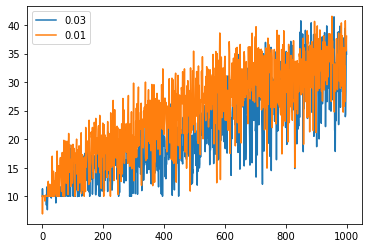

In [98]:
lr_array = [0.03, 0.05, 0.01, 0.005, 0.001]

plt.plot(acc_test_arr_v1[0,0,:],label='0.03')
# plt.plot(acc_test_arr_v1[1,0,:],label='0.05')
plt.plot(acc_test_arr_v1[2,0,:],label='0.01')
# plt.plot(acc_test_arr_v1[3,0,:],label='0.005')
plt.legend()
plt.show()

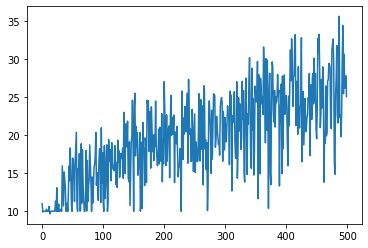

In [91]:
plt.plot(acc_test_arr_v1[0,:])
plt.show()